In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
from fitting_functions import *
import glob
from astropy.constants import c
from astropy.io import ascii
import astropy.units as u
from Borg_emission_lines import lines
import pickle
import random
import pprint
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
os.getcwd()

'c:\\Users\\isaia\\Downloads'

In [4]:
file_spec = 'spectra_13Dec2024_full.p'
with open(file_spec, 'rb') as file:
    data_spec = pickle.load(file)


tab = ascii.read('highz_msaid_public.dat')


In [5]:
borg_ids = ['2426_112','2426_1736','2426_1130','2426_1777','2426_169','2426_1690','2426_1655','1747_199','1747_732','1747_902','1747_1081','1747_817','1747_1425','1747_138']

In [6]:
def get_spec_key(gal):
    PREFERRED_KEYS = [
        'prism-clear',
        'g140h-f100lp',
        'g140m-f100lp',
        'g140m-f070lp',
        'g235h-f170lp',
        'g235m-f170lp',
        'g395h-f290lp',
        'g395m-f290lp'
    ]
    keys = data_spec[gal].keys()
    for k in PREFERRED_KEYS:
        if k in keys:
            return k
    return None  

In [7]:
#This function mimics the provided Spectra Fitting code, but works on a particular set of galaxies individually, by Galaxy ID. Also allows for a custom SNR 

def find_spectral_features(gal_ids, num_bootstraps):
    all_snr_values = []
    # Collect Base SNR in the data set. 
    all_fit_results = []
    for idx, gal in enumerate(gal_ids):
        try:
            spec_key = get_spec_key(gal)
            if spec_key is None:
                print(f"Skipping {gal}: no supported instrument found")
                continue
            itab = np.where(tab['msaid'] == gal)[0]
            z = tab['z'][itab][0]
            wavelength = data_spec[gal][spec_key]['lam']*1e4
            flux_nu = data_spec[gal][spec_key]['flux']
            flux_nu_err = data_spec[gal][spec_key]['err']

            flux_l = convert_fnu_to_flambda(wavelength, flux_nu) * 1.e20
            flux_l_err = convert_fnu_to_flambda(wavelength, flux_nu_err) * 1.e20
            


            # select indices in wavelength array that correspond to our selected wavelength range
            redshift_lines = {key: value * (z + 1) for key, value in lines.items()}
            spectral_windows = {
                'CIV_window': [redshift_lines['CIV_doublet'] - 1500, redshift_lines['CIII]_doublet'] + 1500],
                'OII_window': [redshift_lines['[OII]_doublet'] - 1500, redshift_lines['Hgammma_OIII'] + 1500],
                'Hb_OIII_window': [redshift_lines['Hbeta'] - 1500, redshift_lines['[OIII]_5007'] + 1500]
            }

            # Begin bootstrap sampling:
            N = num_bootstraps
            bootstrap_results = {
                'continuum_slope': [],
                'continuum_intercept': [],
                'line_fluxes': [],  # List of dictionaries, one per iteration
                'flux_ratios': [],  # List of dictionaries, one per iteration
                'amplitudes': [],   # Add amplitudes to the dictionary
                'widths': []        # Add widths to the dictionary
            }   

            
            # **Compute Errors from Bootstrap Samples**
            final_results = {}  # Reset for each galaxy!
            count=0
            for _ in range(N):  # loop over the noise and then get the windows, and at every iteration compute the line fluxes and ratios
                count+=1
                # Generate new spectrum by adding Gaussian noise
                flux_new = flux_l + np.random.normal(0, flux_l_err)

                # Dictionary to store this iteration's line fluxes
                iteration_fluxes = {}
                iteration_ratios = {}
                iteration_amplitudes = {}
                iteration_widths = {}

                for window_name, window_range in spectral_windows.items():
                    sliced_index = np.where((wavelength >= window_range[0]) & (wavelength <= window_range[1]))
                    window_wavelength = wavelength[sliced_index]
                    window_flux = flux_l[sliced_index]
                    window_flux_err = flux_l_err[sliced_index]
                    invalid_spec = np.where((np.isfinite(window_flux) == False) | (np.isfinite(window_flux_err) == False))
                    window_flux[invalid_spec] = 0.
                    window_flux_err[invalid_spec] = 1.e20
            
                    model = models.Polynomial1D(1)
                    Nlines = 0

                    for key in redshift_lines:
                        lam = redshift_lines[key]
                        if (lam < np.nanmin(window_wavelength)) | (lam > np.nanmax(window_wavelength)):
                            continue

                        line = models.Gaussian1D(amplitude=np.nanmax(window_flux[(window_wavelength > (lam - 100.)) & (window_wavelength < (lam + 100.))]),
                                                mean=lam, stddev=60)
                        line.amplitude.min = 0.  # 1.e-3
                        line.amplitude.max = np.nanmax(window_flux[(window_wavelength > (lam - 100.)) & (window_wavelength < (lam + 100.))])
                        line.amplitude.fixed = False
                        line.stddev.min = 0.  # 1.e-3
                        line.stddev.fixed = False
                        model += line
                        Nlines += 1

                    # Fit model:
                    fit_g = fitting.LevMarLSQFitter(calc_uncertainties=True)
                    g = fit_g(model, window_wavelength, flux_new[sliced_index], weights=1 / window_flux_err)
                    # Check fit status using fit_info
                    status = fit_g.fit_info.get('status')

                
                    # Store bootstrapped parameters for this iteration
                    bootstrap_results['continuum_slope'].append(g.parameters[0])  # Use g.parameters[0] for the slope (c0)
                    bootstrap_results['continuum_intercept'].append(g.parameters[1])  # Use g.parameters[1] for the intercept (c1)


                    #for line_name, lam in redshift_lines.items():
                    for i, line_name in enumerate([key for key in redshift_lines if redshift_lines[key] >= np.nanmin(window_wavelength) and redshift_lines[key] <= np.nanmax(window_wavelength)]):

                        #print(line_name)
                        amp = getattr(g, f'amplitude_{i+1}').value
                        width = getattr(g, f'stddev_{i+1}').value

                        # Store in dictionaries for later error calculation
                        if line_name not in iteration_amplitudes:
                            iteration_amplitudes[line_name] = []
                            iteration_widths[line_name] = []

                        iteration_amplitudes[line_name].append(amp)
                        iteration_widths[line_name].append(width)

                        # **Compute line flux**
                        flux = amp * width * np.sqrt(2 * np.pi) * 1.e-2
                        iteration_fluxes[f"{line_name}_flux"] = flux
                    # print(count) #correctly goes throush the 3 spectral windows and finds fluxes for all lines, this for 100 times


                # **Compute flux ratios**
                # print(iteration_fluxes) #Fluxes saved correctly! No overwritting
                if '[NeIII]_flux' in iteration_fluxes and '[OII]_doublet_flux' in iteration_fluxes:
                    iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']

                if '[OIII]_5007_flux' in iteration_fluxes and 'Hbeta_flux' in iteration_fluxes:
                    iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']

                if 'Hdelta_flux' in iteration_fluxes and 'Hbeta_flux' in iteration_fluxes:
                    iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']

                if 'Hgammma_OIII_flux' in iteration_fluxes and 'Hbeta_flux' in iteration_fluxes:
                    iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']



                # Debugging: Print ratios for each iteration
                #print(f"Iteration {count} flux ratios: {iteration_ratios}") This worked!

                # Store this bootstrap iteration's results
                bootstrap_results['line_fluxes'].append(iteration_fluxes)
                bootstrap_results['flux_ratios'].append(iteration_ratios)
                bootstrap_results['amplitudes'].append(iteration_amplitudes)
                bootstrap_results['widths'].append(iteration_widths)

            # Now that all bootstrap iterations are done, plot and save the fit for each spectral window
            for window_name, window_range in spectral_windows.items():
                sliced_index = np.where((wavelength >= window_range[0]) & (wavelength <= window_range[1]))
                window_wavelength = wavelength[sliced_index]
                window_flux = flux_l[sliced_index]
                window_flux_err = flux_l_err[sliced_index]

                # Define the model and fit it
                model = models.Polynomial1D(1)
                Nlines = 0

                for key in redshift_lines:
                    lam = redshift_lines[key]
                    if (lam < np.nanmin(window_wavelength)) | (lam > np.nanmax(window_wavelength)):
                        continue

                    line = models.Gaussian1D(
                        amplitude=np.nanmax(window_flux[(window_wavelength > (lam - 100.)) & (window_wavelength < (lam + 100.))]),
                        mean=lam, stddev=60
                    )
                    line.amplitude.min = 0.
                    line.amplitude.max = np.nanmax(window_flux[(window_wavelength > (lam - 100.)) & (window_wavelength < (lam + 100.))])
                    model += line
                    Nlines += 1

                # Fit the model to the spectrum
                fit_g = fitting.LevMarLSQFitter(calc_uncertainties=True)
                g = fit_g(model, window_wavelength, window_flux, weights=1 / window_flux_err, maxiter=10000, estimate_jacobian=True)

                #############################################################################################################
                #Add Fit Diagnostics (Metric to see which galaxies fit poorly) 
                #Compute RMSE of residual, coming from subtracting observed flux in specific wavelength from the
                #fit function to the data in that same wavelength window 
                residuals = window_flux - g(window_wavelength)
                
                rms = np.sqrt(np.mean(residuals**2)) 
                print(f"RMS for {gal} in {window_name}: {rms:.4g}")
                final_results[f"{window_name}_fit_rms"] = rms
                
                
                #############################################################################################################
                # Plot and save the fit for each spectral window
                fig = plt.figure(figsize=(7, 7))
                plt.title(gal + " - " + window_name, fontsize=16)
                plt.step(window_wavelength, window_flux, where='mid', color='k', label='Data')  # Original data
                plt.step(window_wavelength, window_flux_err, where='mid', color='grey', linestyle='dotted', label='Error')  # Error bars
                residuals = window_flux - g(window_wavelength)  # Residuals
                plt.step(window_wavelength, residuals, where='mid', color='orange', label='Residuals')  # Residuals
                plt.plot(window_wavelength, g(window_wavelength), color='red', label='Fit')  # Model fit

                plt.xlabel(r"Wavelength ($\AA$)", fontsize=18)
                plt.ylabel(r"Flux (erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)", fontsize=18)
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)

                # Save the plot as a PNG (or any other format)
                plot_filename = f"Figures_spectra/fit_{gal}_{window_name}.png"
                plt.savefig(plot_filename)  # Save the figure with a unique filename based on the window name

                plt.close()  # Close the plot after saving

            # **Find all emission lines across bootstraps**
            all_detected_lines = set()
            for iteration in bootstrap_results['line_fluxes']:
                all_detected_lines.update(iteration.keys())  # Collect all line_flux keys

            # **Compute errors for all detected lines**
            for line in all_detected_lines:
                flux_values = [iteration[line] for iteration in bootstrap_results['line_fluxes'] if line in iteration]
                if len(flux_values) > 0:  # Ensure at least one detection
                    flux_16, flux_median, flux_84 = np.percentile(flux_values, [16, 50, 84])
                    final_results[line] = flux_median
                    final_results[f"{line}_err"] = np.array([flux_median - flux_16, flux_84 - flux_median])  # Asymmetric errors
                    err_minus = flux_median - flux_16
                    err_plus = flux_84 - flux_median 
                    avg_error = (err_minus + err_plus) / 2 #Gives STD. 
                    line_SNR = flux_median / avg_error if avg_error > 0 else 0 #Avoid divisions by 0
                    final_results[f"{line}_SNR"] = line_SNR #Store SNR Values
                    
            #SNR Checking       
        
            # **Compute errors for flux ratios**
            for ratio in ['NeIII_OII_ratio', 'OIII5007_Hbeta_ratio','Hdelta_Hbeta_ratio','Hgamma_Hbeta_ratio']:
                ratio_values = [iteration[ratio] for iteration in bootstrap_results['flux_ratios'] if ratio in iteration]
                if len(ratio_values) > 0:
                    ratio_16, ratio_median, ratio_84 = np.percentile(ratio_values, [16, 50, 84])
                    final_results[ratio] = ratio_median
                    final_results[f"{ratio}_err"] = np.array([ratio_median - ratio_16, ratio_84 - ratio_median])  
                    ratio_minus = ratio_median - ratio_16
                    ratio_plus = ratio_84 - ratio_median
                    avg_ratio = (ratio_minus + ratio_plus) / 2 
                    ratio_SNR = ratio_median / avg_ratio if avg_ratio > 0 else 0 
                    final_results[f"{ratio}_SNR"] = ratio_SNR

            # Append results **per galaxy**
            all_fit_results.append({gal: final_results})
            print(f"Final results for {gal}:", final_results.keys())
        except Exception as e: 
            print(f"Failed on {gal} due to: {e}")
    print(f"Processed {len(all_fit_results)} galaxies")
    return(all_fit_results)
                          
    
                          
                          


In [8]:
borg_survey_data_results = find_spectral_features(borg_ids, 100)

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


RMS for 2426_112 in CIV_window: 0.4326
RMS for 2426_112 in OII_window: 0.1854
RMS for 2426_112 in Hb_OIII_window: 0.1606
Final results for 2426_112: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SN

C:\Users\isaia\AppData\Local\Temp\ipykernel_3296\1975054912.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_3296\1975054912.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_3296\1975054912.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_3296\1975054912.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipyk

RMS for 2426_1130 in CIV_window: 0.3944
RMS for 2426_1130 in OII_window: 0.2191
RMS for 2426_1130 in Hb_OIII_window: 0.2504


c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Final results for 2426_1130: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'NeIII_OII_ratio_SNR', 'OIII5007_Hbeta_ratio', 'OIII5007_Hbeta_ratio_err', 'OIII5007_Hbeta_ratio_SNR', 'Hdelta_Hbeta_ratio', 'Hdelta_

In [13]:
import pandas as pd

rows = []

# Iterate over the list
for item in borg_survey_data_results:
    # Each `item` is a dict with one key-value pair
    for gal_id, data in item.items():
        row = {'Galaxy ID': gal_id}
        for key, value in data.items():
            row[key] = value
        rows.append(row)

df = pd.DataFrame(rows)


,Galaxy ID,[OIII]_5007_flux,NeIII_OII_ratio
0,2426_112,19.628962,2.510568
1,2426_1736,14.094684,0.460548
2,2426_1130,5.509187,NaN
3,2426_1777,12.889863,0.869817
4,2426_169,66.019032,2.763353
5,2426_1690,13.186433,0.034636
6,2426_1655,27.697835,0.455974
7,1747_199,11.112280,0.528025
8,1747_732,10.873975,0.680506
9,1747_902,16.863161,0.538705


In [50]:
df[[col for col in df.columns if col.endswith('flux')]]

,Hgammma_OIII_flux,[OIII]_5007_flux,MgI_5174_flux,OIII]_doublet_flux,Hepsilon_flux,CIV_doublet_flux,[OII]_doublet_flux,CIII]_doublet_flux,[OIII]_4959_flux,Hbeta_flux,[NeIII]_flux,Hdelta_flux
0,3.401637,19.628962,0.000000,0.001877,1.644631,3.263115,1.393354,5.062197,6.468173,3.123132,3.745405,0.837276
1,0.825914,14.094684,NaN,0.000000,0.808290,0.000000,2.877245,2.515351,5.030962,2.228338,1.330624,0.496103
2,1.055419,5.509187,NaN,0.000000,0.063136,0.465932,0.625384,0.000000,1.208734,1.125897,0.163887,0.642609
3,1.521074,12.889863,NaN,1.386570,0.424494,0.117492,1.046253,0.672599,5.799354,2.445209,0.935739,0.202502
4,7.642046,66.019032,NaN,4.987771,2.057505,1.171784,1.968144,5.491365,24.315587,12.512720,5.824440,2.426868
5,0.855928,13.186433,NaN,0.000000,0.000000,0.000000,1.474118,0.299389,5.265266,2.316765,0.055277,0.000000
6,3.113773,27.697835,NaN,2.805757,0.895536,1.137265,3.353598,2.406461,9.644420,6.338540,1.545958,1.462978
7,0.494552,11.112280,NaN,2.449074,0.575358,0.000000,1.474675,0.614493,4.482570,2.318455,0.792687,0.317284
8,1.090507,10.873975,NaN,1.738205,0.534439,0.000000,1.008966,2.525336,2.602087,1.491600,0.624675,0.421951
9,1.000135,16.863161,NaN,2.222454,0.489941,0.000000,1.975249,2.449586,5.571724,2.626393,0.910722,0.413269


## Making the Merged DF (Combining the Raw data with the processed test data)

In [28]:
colnames = ['survey', 'field', 'prog_id', 'id', 'msaid', 'ra', 'dec', 'z', 
            'flag_lya', 'flag_agn', 'flag_z']

raw_df = pd.read_csv(
    'highz_msaid_public.dat',
    comment='#',
    delim_whitespace=True,
    names=colnames,
    header=None
)


C:\Users\isaia\AppData\Local\Temp\ipykernel_2632\2117120511.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  raw_df = pd.read_csv(


In [29]:
import os 
print("Working directory:", os.getcwd())

Working directory: c:\Users\isaia\Downloads


In [30]:
test_df = pd.read_csv('test_data.csv')
test_df

,Galaxy ID,Hdelta_flux,Hdelta_flux_err,CIII]_doublet_flux,CIII]_doublet_flux_err,Hbeta_flux,Hbeta_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_err,OIII]_doublet_flux,...,CIV_doublet_flux,CIV_doublet_flux_err,NeIII_OII_ratio,NeIII_OII_ratio_err,OIII5007_Hbeta_ratio,OIII5007_Hbeta_ratio_err,Hdelta_Hbeta_ratio,Hdelta_Hbeta_ratio_err,Hgamma_Hbeta_ratio,Hgamma_Hbeta_ratio_err
0,['1180_5173'],21.610712,[21.61071236 17.90707177],115.647909,[ 115.64790896 1793.81074923],42.848565,[11.41621062 8.9707471 ],196.938891,[13.33074582 19.54452065],1.601763,...,3.887884,[ 3.88788358 65.37927077],NaN,[nan nan],4.654061,[1.02530249 1.73274227],0.456753,[0.45675286 0.59044257],0.361168,[0.22378738 0.32377442]
1,['1180_12637'],37.465910,[4.07258171 5.25004749],156.853134,[11.61272972 11.65384389],177.616830,[ 8.55586116 12.01248559],1169.089250,[13.31482819 13.03653931],173.169952,...,0.000000,[ 0. 19.04562504],1.008395,[0.24115302 0.38314679],6.546541,[0.37765031 0.39359899],0.210067,[0.02665777 0.02674623],0.623910,[0.07816934 0.06524262]
2,['1180_13908'],8.403467,[8.4034667 9.96392459],6.090556,[ 6.09055619 29.95439822],-0.000000,[4.77325558 0. ],17.151145,[ 7.75948391 12.01455309],0.000000,...,0.000000,[0. 0.],NaN,[nan nan],NaN,[nan nan],NaN,[nan nan],NaN,[nan nan]
3,['1180_17038'],0.000000,[ 0. 41.0278874],0.000000,[ 0. 16.70074531],6.587836,[ 6.58783604 15.40661249],82.467580,[14.3035984 16.74029923],0.000000,...,85.394319,[ 85.39431863 110.33477274],NaN,[nan nan],12.688654,[9.08081486 nan],NaN,[nan nan],NaN,[nan nan]
4,['1180_13552'],23.516724,[ 5.03150409 13.14763735],35.563380,[35.5633798 36.98218732],68.234344,[18.22386839 17.91411083],337.655330,[10.71907242 11.26487216],104.711722,...,0.000000,[ 0. 41.23473944],0.556749,[0.17649422 0.34288866],5.060749,[1.19769404 1.83927126],0.388930,[0.13508025 0.19267676],0.737852,[0.50470799 0.52184487]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,['3073_66908'],137.764868,[17.23448421 14.46268681],0.000000,[ 0. 87.16015665],7.737576,[7.73757628 9.22389538],45.682636,[6.5635237 6.1198311],107.306801,...,62.921074,[62.92107361 56.85251123],NaN,[nan nan],5.752313,[2.95203596 nan],16.590977,[8.72436917 nan],NaN,[nan nan]
1176,['3073_10413'],10.809787,[10.80978724 16.20374251],8.101809,[ 8.10180897 56.51107604],36.505921,[ 8.97769869 12.04834454],79.483583,[12.94006232 16.47785955],0.000000,...,42.952123,[ 42.95212321 113.46151681],NaN,[nan nan],2.118530,[0.47344353 1.03977362],0.310167,[0.310167 0.61282652],1.136064,[0.73368358 0.83095274]
1177,['3073_11646'],21.482843,[21.48284291 11.13927583],0.000000,[0. 1.66150516],0.000000,[0. 2.49166768],58.896364,[ 9.05895442 12.82004455],0.000000,...,139.975961,[70.72309808 25.71160731],NaN,[nan nan],NaN,[nan nan],NaN,[nan nan],NaN,[nan nan]
1178,['2426_112'],82.569195,[16.55834995 17.37931243],491.353776,[87.84481799 60.55505766],300.720007,[37.1865746 39.46707366],1960.771640,[ 92.31256513 108.64089037],0.000000,...,324.534639,[324.53463851 230.36625948],2.325962,[1.14701764 0.98690742],6.584859,[1.00142568 0.90369722],0.272111,[0.0622656 0.0892465],1.134382,[0.42355037 0.23538896]


In [31]:
raw_df.rename(columns={'msaid':'Galaxy ID'}, inplace=True)

In [32]:
# Ensure all are strings
test_df['Galaxy ID'] = test_df['Galaxy ID'].apply(lambda x: x[0] if isinstance(x, list) else x)
test_df['Galaxy ID'] = test_df['Galaxy ID'].astype(str).str.strip()

raw_df['Galaxy ID'] = raw_df['Galaxy ID'].astype(str).str.strip()


In [33]:
import ast
## Clean the Galaxy ID column in test df to match raw df
def clean_id(val):
    # If it's already a list (real Python list), take first element
    if isinstance(val, list):
        return val[0]
    # If it's a string that "looks like a list", parse and take first element
    elif isinstance(val, str) and val.startswith("[") and val.endswith("]"):
        parsed = ast.literal_eval(val)
        return parsed[0]
    else:
        return val

test_df['Galaxy ID'] = test_df['Galaxy ID'].apply(clean_id).astype(str).str.strip()
raw_df['Galaxy ID'] = raw_df['Galaxy ID'].astype(str).str.strip()


In [34]:
merged_df = pd.merge(test_df, raw_df, on='Galaxy ID', how='outer')
# Clean Galaxy ID in merged_df explicitly after merge:
merged_df['Galaxy ID'] = merged_df['Galaxy ID'].apply(clean_id).astype(str).str.strip()
print(f"Length of Merged DF: {len(merged_df['Galaxy ID'])}")

Length of Merged DF: 1364


Might need to change the code below to apply the log to **all** line ratio columns (Not sure about some like Hdelta_Hbeta for example)

In [53]:
merged_df['NeIII_OII_ratio_log'] = np.log(np.array(merged_df['NeIII_OII_ratio']))
merged_df['OIII5007_Hbeta_ratio_log'] = np.log(np.array(merged_df['OIII5007_Hbeta_ratio']))
merged_df[[col for col in merged_df.columns if col.endswith('ratio_log')]]

C:\Users\isaia\AppData\Local\Temp\ipykernel_3296\1874559649.py:1: RuntimeWarning: divide by zero encountered in log
  merged_df['NeIII_OII_ratio_log'] = np.log(np.array(merged_df['NeIII_OII_ratio']))
C:\Users\isaia\AppData\Local\Temp\ipykernel_3296\1874559649.py:1: RuntimeWarning: invalid value encountered in log
  merged_df['NeIII_OII_ratio_log'] = np.log(np.array(merged_df['NeIII_OII_ratio']))
C:\Users\isaia\AppData\Local\Temp\ipykernel_3296\1874559649.py:2: RuntimeWarning: invalid value encountered in log
  merged_df['OIII5007_Hbeta_ratio_log'] = np.log(np.array(merged_df['OIII5007_Hbeta_ratio']))


,NeIII_OII_ratio_log,OIII5007_Hbeta_ratio_log
0,-0.622097,1.860217
1,-0.018136,2.216351
2,NaN,1.181180
3,-1.869067,1.628074
4,NaN,2.314940
...,...,...
1359,NaN,1.145912
1360,0.976801,1.424508
1361,-0.644907,1.164089
1362,-1.467135,1.898935


In [46]:
borg = merged_df[merged_df['survey'] =='borg']

borg.sort_values('z', inplace= True)

borg[['Galaxy ID', 'z', '[OIII]_5007_flux', 'NeIII_OII_ratio_log']]



C:\Users\isaia\AppData\Local\Temp\ipykernel_3296\3088395487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  borg.sort_values('z', inplace= True)


,Galaxy ID,z,[OIII]_5007_flux,NeIII_OII_ratio_log
658,1747_412,5.755,5.308791,-0.303485
653,1747_1257,5.891,1.782074,NaN
659,1747_528,6.021,5.432436,-0.893731
657,1747_269,6.290,NaN,NaN
652,1747_1084,6.305,12.157436,-0.253451
660,1747_587,6.512,1.391120,NaN
664,1747_m5,6.525,23.831459,-0.367601
654,1747_138,7.179,7.529795,-0.318553
655,1747_1425,7.553,16.283600,0.304619
662,1747_817,7.556,20.701394,-0.735800


In [44]:
merged_df = pd.read_csv('Test_Dataframe.csv')
flux_cols = [col for col in merged_df.columns if col.endswith('flux')]
merged_df[flux_cols] = merged_df[flux_cols] * (10e-3)

In [35]:
merged_df

,Galaxy ID,Hdelta_flux,Hdelta_flux_err,CIII]_doublet_flux,CIII]_doublet_flux_err,Hbeta_flux,Hbeta_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_err,OIII]_doublet_flux,...,survey,field,prog_id,id,ra,dec,z,flag_lya,flag_agn,flag_z
0,1180_10013169,120.413826,[ 8.41240806 10.9851172 ],245.735973,[245.73597344 93.95146 ],363.780839,[20.26336168 20.81127962],2330.430850,[105.61302789 107.90334416],0.000000,...,jades,gds,1180,10013169,53.200596,-27.804979,5.040,-99,-99,-99
1,1180_10013534,20.727099,[20.72709884 9.33488842],94.210513,[63.60078564 31.46679781],74.078232,[ 7.26015404 10.01117818],678.746239,[16.40896544 16.76749229],29.110288,...,jades,gds,1180,10013534,53.205320,-27.804598,5.378,-99,-99,-99
2,1180_103483,1.393907,[ 1.3939075 12.54162212],34.940939,[34.94093874 76.52243574],89.124771,[22.60059519 18.16104472],291.710588,[22.76038817 26.73638848],78.663970,...,jades,gds,1180,103483,53.188311,-27.812834,5.265,-99,-99,-99
3,1180_11547,10.965329,[10.96532879 15.29253411],109.609389,[76.70671565 51.90466314],105.968692,[26.44070371 40.48913407],541.932670,[20.82428297 20.7014439 ],0.000000,...,jades,gds,1180,11547,53.164831,-27.788257,7.241,0,0,-99
4,1180_12336,38.784689,[38.78468939 26.99886202],0.258767,[ 0.25876679 45.14417216],31.087272,[31.08727231 12.95174967],320.512085,[36.91888481 37.86796997],2.938078,...,jades,gds,1180,12336,53.162327,-27.766873,5.917,-99,-99,-99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,4233_978590,0.000000,[ 0. 35.17725989],36.737035,[ 36.73703484 100.25730746],52.278133,[30.52998994 43.01151429],160.283933,[33.59904686 28.02776786],77.197574,...,rubies,egs,4233,978590,214.830660,52.887775,7.766,0,0,-99
1360,4233_980841,63.733961,[12.39510965 13.7804068 ],149.561573,[ 40.83127875 141.85147826],311.981321,[31.7902677 27.87505309],1290.883008,[24.62358525 25.08614451],0.000000,...,rubies,egs,4233,980841,214.844770,52.892109,8.694,-99,1,-99
1361,4233_9809,0.884158,[ 0.88415755 14.65879785],0.000000,[ 0. 109.52813267],99.238123,[10.96368124 10.80448298],302.541501,[ 29.55329916 154.09038363],-35.515211,...,rubies,egs,4233,9809,215.017298,52.880158,5.689,-99,-99,-99
1362,4233_986615,14.131440,[14.13144021 27.14881396],164.069899,[125.59493873 55.59106764],113.237788,[24.10241051 33.88260355],739.018990,[22.92916939 25.43113271],242.799688,...,rubies,egs,4233,986615,214.950932,52.957040,6.502,-99,-99,-99


In [48]:
merged_df.to_csv('Test_Dataframe.csv', index = False)

# Bin Making

In [37]:
survey_galaxies = {} 

for survey in set(merged_df['survey']): 
    survey_galaxies[f"{survey}_galaxies"] = merged_df[merged_df['survey'] == survey]


list(survey_galaxies.keys())

['smacs_galaxies',
 'kelly_galaxies',
 'borg_galaxies',
 'chen_galaxies',
 'eisenstein_galaxies',
 'jades_galaxies',
 'glazebrook_galaxies',
 'arrabal_galaxies',
 'castellano_galaxies',
 'coe_galaxies',
 'rubies_galaxies',
 'ceers_galaxies',
 'canucs_galaxies',
 'borg_fs_galaxies',
 'uncover_galaxies',
 'stark_galaxies',
 'glass_galaxies']

In [ ]:
borg_ids = ['2426_112','2426_1736','2426_1130','2426_1777','2426_169','2426_1690','2426_1655','1747_199','1747_732','1747_902','1747_1081','1747_817','1747_1425','1747_138']

In [ ]:
borg_ids

['2426_112',
 '2426_1736',
 '2426_1130',
 '2426_1777',
 '2426_169',
 '2426_1690',
 '2426_1655',
 '1747_199',
 '1747_732',
 '1747_902',
 '1747_1081',
 '1747_817',
 '1747_1425',
 '1747_138']

In [ ]:
with open('test_data_fit_results_ratios.pkl', 'wb') as f:
    pickle.dump(borg_survey_data_results, f)

In [ ]:
with open('test_data_fit_results_ratios.pkl', 'rb') as f:
    borg_survey_data_results = pickle.load(f)

## Putting the survey files into dataframes 

In [ ]:
all_keys = set() #Enforce all keys are unique 

for galaxy in borg_survey_data_results:
    g_id = list(galaxy.keys())[0]
    all_keys.update(galaxy[g_id].keys())

In [ ]:
def grab_data(galaxy, data):
    g_id = list(galaxy.keys())[0] 
    return galaxy[g_id].get(data, np.nan)




data_dict = {key: [] for key in all_keys}
for galaxy in borg_survey_data_results: 
    for key in data_dict:
        data_dict[key].append(grab_data(galaxy, key))

## Ensure each Key has same number of entries and matches number of galaxies. 
for key in data_dict: 
    print(f"Length of {key}: {len(data_dict[key])}")

Length of Hdelta_flux: 14
Length of Hb_OIII_window_fit_rms: 14
Length of CIV_doublet_flux_err: 14
Length of Hdelta_flux_err: 14
Length of [OII]_doublet_flux_err: 14
Length of Hbeta_flux: 14
Length of OIII]_doublet_flux_SNR: 14
Length of OIII]_doublet_flux_err: 14
Length of Hgamma_Hbeta_ratio: 14
Length of Hepsilon_flux: 14
Length of OIII]_doublet_flux: 14
Length of Hdelta_Hbeta_ratio_err: 14
Length of [OIII]_4959_flux: 14
Length of NeIII_OII_ratio_SNR: 14
Length of Hdelta_flux_SNR: 14
Length of MgI_5174_flux_err: 14
Length of Hgammma_OIII_flux_err: 14
Length of CIII]_doublet_flux_SNR: 14
Length of [OIII]_4959_flux_SNR: 14
Length of MgI_5174_flux_SNR: 14
Length of OIII5007_Hbeta_ratio_SNR: 14
Length of MgI_5174_flux: 14
Length of [OIII]_4959_flux_err: 14
Length of CIII]_doublet_flux: 14
Length of Hbeta_flux_SNR: 14
Length of OIII5007_Hbeta_ratio_err: 14
Length of CIV_doublet_flux_SNR: 14
Length of Hgamma_Hbeta_ratio_err: 14
Length of Hdelta_Hbeta_ratio_SNR: 14
Length of [NeIII]_flux_SNR

In [ ]:
borg_df = pd.DataFrame(data_dict)

In [ ]:
borg_df_ids = [ ] 

for i in range(len(borg_survey_data_results)):
    borg_df_ids.append(list(borg_survey_data_results[i].keys()))

In [ ]:
borg_df['Galaxy ID'] = borg_df_ids

In [ ]:
df[[col for col in df.columns if col.endswith('SNR')]]

,Hepsilon_flux_SNR,MgI_5174_flux_SNR,OIII]_doublet_flux_SNR,CIV_doublet_flux_SNR,[OII]_doublet_flux_SNR,Hgammma_OIII_flux_SNR,[NeIII]_flux_SNR,Hdelta_flux_SNR,CIII]_doublet_flux_SNR,Hbeta_flux_SNR,[OIII]_5007_flux_SNR,[OIII]_4959_flux_SNR,NeIII_OII_ratio_SNR,OIII5007_Hbeta_ratio_SNR,Hdelta_Hbeta_ratio_SNR,Hgamma_Hbeta_ratio_SNR
0,2.816204,0.000000,0.000000,1.052542,2.243906,3.763627,4.070766,2.471021,6.994314,6.054540,24.014764,11.135757,2.887693,5.447302,2.103063,3.232062
1,4.848366,NaN,0.000000,0.000000,4.311676,3.840473,2.375688,1.712998,4.797309,7.743422,47.825045,18.934205,2.737991,6.851230,1.673486,3.054638
2,0.198673,NaN,0.000000,0.588803,1.226960,1.786821,0.527719,0.895197,0.000000,2.420185,9.404254,2.030582,0.000000,1.789780,0.652076,1.168098
3,1.615373,NaN,1.395486,0.000000,1.624709,4.108766,2.516189,0.552502,1.062414,4.740416,34.480717,12.052514,1.175698,5.191124,0.492850,2.973492
4,3.340968,NaN,1.354672,0.908888,6.674698,5.588584,2.445358,3.436720,5.885598,20.287936,99.269494,38.295089,2.689458,20.930647,3.640441,5.209895
5,0.000000,NaN,0.000000,0.000000,2.296377,1.358489,0.000000,0.000000,0.260618,1.512806,22.436269,9.876551,0.000000,1.355953,0.000000,0.858672
6,1.084026,NaN,0.000000,0.656110,3.894245,1.509201,1.105453,1.627870,2.106687,9.496951,42.718401,16.256947,1.462198,8.627529,1.569768,1.431849
7,6.721123,NaN,3.307128,0.000000,7.068508,1.983748,7.055957,1.407027,0.545685,10.664428,44.157674,18.215123,5.507164,9.589275,1.405460,1.901141
8,4.174174,NaN,1.817408,0.000000,4.552633,1.880704,1.380031,1.583558,3.195861,4.422361,36.856480,8.179747,1.090289,4.310714,1.251919,1.703429
9,1.952783,NaN,1.414187,0.000000,4.776750,2.212100,2.324840,2.579979,2.617838,11.481392,53.678336,18.304433,2.594407,11.022431,2.537458,2.143450


In [ ]:
with open('test_data_fit_results_ratios.pkl', 'rb') as f:
        survey_results = pickle.load(f)

survey_results

[{'1747_1081': {'CIV_window_fit_rms': 0.28232579256137463,
   'OII_window_fit_rms': 0.14960066831613927,
   'Hb_OIII_window_fit_rms': 0.1461394611187035,
   'Hdelta_flux': 36.778544678912,
   'Hdelta_flux_err': array([35.69991767, 44.62821294]),
   'Hdelta_flux_SNR': 0.9157077203048618,
   'Hgammma_OIII_flux': 90.15481945326547,
   'Hgammma_OIII_flux_err': array([53.2323277, 52.7026962]),
   'Hgammma_OIII_flux_SNR': 1.702077672366621,
   '[OII]_doublet_flux': 192.02929957451454,
   '[OII]_doublet_flux_err': array([75.94050445, 41.7635386 ]),
   '[OII]_doublet_flux_SNR': 3.2629176465755956,
   'Hbeta_flux': 133.95072823428177,
   'Hbeta_flux_err': array([53.43014049, 32.45922445]),
   'Hbeta_flux_SNR': 3.11914585308536,
   'CIII]_doublet_flux': 123.69290755309302,
   'CIII]_doublet_flux_err': array([101.88825292,  52.22454849]),
   'CIII]_doublet_flux_SNR': 1.605225606499909,
   '[OIII]_5007_flux': 426.4895513795511,
   '[OIII]_5007_flux_err': array([28.18393944, 30.92506597]),
   '[OII

In [ ]:
merged_df

,Galaxy ID,Hdelta_flux,Hdelta_flux_err,CIII]_doublet_flux,CIII]_doublet_flux_err,Hbeta_flux,Hbeta_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_err,OIII]_doublet_flux,...,survey,field,prog_id,id,ra,dec,z,flag_lya,flag_agn,flag_z
0,1180_10013169,120.413826,[ 8.41240806 10.9851172 ],245.735973,[245.73597344 93.95146 ],363.780839,[20.26336168 20.81127962],2330.430850,[105.61302789 107.90334416],0.000000,...,jades,gds,1180,10013169,53.200596,-27.804979,5.040,-99,-99,-99
1,1180_10013534,20.727099,[20.72709884 9.33488842],94.210513,[63.60078564 31.46679781],74.078232,[ 7.26015404 10.01117818],678.746239,[16.40896544 16.76749229],29.110288,...,jades,gds,1180,10013534,53.205320,-27.804598,5.378,-99,-99,-99
2,1180_103483,1.393907,[ 1.3939075 12.54162212],34.940939,[34.94093874 76.52243574],89.124771,[22.60059519 18.16104472],291.710588,[22.76038817 26.73638848],78.663970,...,jades,gds,1180,103483,53.188311,-27.812834,5.265,-99,-99,-99
3,1180_11547,10.965329,[10.96532879 15.29253411],109.609389,[76.70671565 51.90466314],105.968692,[26.44070371 40.48913407],541.932670,[20.82428297 20.7014439 ],0.000000,...,jades,gds,1180,11547,53.164831,-27.788257,7.241,0,0,-99
4,1180_12336,38.784689,[38.78468939 26.99886202],0.258767,[ 0.25876679 45.14417216],31.087272,[31.08727231 12.95174967],320.512085,[36.91888481 37.86796997],2.938078,...,jades,gds,1180,12336,53.162327,-27.766873,5.917,-99,-99,-99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,4233_978590,0.000000,[ 0. 35.17725989],36.737035,[ 36.73703484 100.25730746],52.278133,[30.52998994 43.01151429],160.283933,[33.59904686 28.02776786],77.197574,...,rubies,egs,4233,978590,214.830660,52.887775,7.766,0,0,-99
1360,4233_980841,63.733961,[12.39510965 13.7804068 ],149.561573,[ 40.83127875 141.85147826],311.981321,[31.7902677 27.87505309],1290.883008,[24.62358525 25.08614451],0.000000,...,rubies,egs,4233,980841,214.844770,52.892109,8.694,-99,1,-99
1361,4233_9809,0.884158,[ 0.88415755 14.65879785],0.000000,[ 0. 109.52813267],99.238123,[10.96368124 10.80448298],302.541501,[ 29.55329916 154.09038363],-35.515211,...,rubies,egs,4233,9809,215.017298,52.880158,5.689,-99,-99,-99
1362,4233_986615,14.131440,[14.13144021 27.14881396],164.069899,[125.59493873 55.59106764],113.237788,[24.10241051 33.88260355],739.018990,[22.92916939 25.43113271],242.799688,...,rubies,egs,4233,986615,214.950932,52.957040,6.502,-99,-99,-99


In [ ]:
def get_df(survey,num_bootstraps, z_min, z_max):
    survey_df = merged_df[merged_df['survey'] == survey]
    survey_ids =  list(survey_df[(survey_df['z'] > z_min) & (survey_df['z'] < z_max)]['Galaxy ID'])
    results = find_spectral_features(survey_ids, num_bootstraps)
    with open('test_data_fit_results_ratios.pkl', 'wb') as f:
        pickle.dump(results, f)
    with open('test_data_fit_results_ratios.pkl', 'rb') as f:
        survey_results = pickle.load(f)
    keys_set = set()
    for galaxy in survey_results:
        gal_id, result_dict = list(galaxy.items())[0]
        keys_set.update(result_dict.keys())

    all_keys = sorted(list(keys_set))
    dictionary = {key: [] for key in all_keys}
    gal_ids = []

    for galaxy in survey_results: 
        gal_id, result_dict = list(galaxy.items())[0]
        gal_ids.append(gal_id)  # Keep Galaxy ID
        for key in all_keys:
            dictionary[key].append(result_dict.get(key, np.nan))

    
    survey_df = pd.DataFrame(dictionary)
    survey_df.insert(0, 'Galaxy ID', gal_ids)
    #Add the galaxy ids 
    
    return survey_df
          



In [ ]:
borg_get = get_df('borg', 100, 7.5, 8.5)

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


RMS for 1747_1081 in CIV_window: 0.2823
RMS for 1747_1081 in OII_window: 0.1496
RMS for 1747_1081 in Hb_OIII_window: 0.1461
Final results for 1747_1081: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'NeIII_OI

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 1747_1425 in CIV_window: 0.3289
RMS for 1747_1425 in OII_window: 0.1633
RMS for 1747_1425 in Hb_OIII_window: 0.1613
Final results for 1747_1425: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flu

In [ ]:
borg_get[[col for col in borg_get.columns if col.endswith('SNR')]]

,CIII]_doublet_flux_SNR,CIV_doublet_flux_SNR,Hbeta_flux_SNR,Hdelta_Hbeta_ratio_SNR,Hdelta_flux_SNR,Hepsilon_flux_SNR,Hgamma_Hbeta_ratio_SNR,Hgammma_OIII_flux_SNR,MgI_5174_flux_SNR,NeIII_OII_ratio_SNR,OIII5007_Hbeta_ratio_SNR,OIII]_doublet_flux_SNR,[NeIII]_flux_SNR,[OIII]_4959_flux_SNR,[OIII]_5007_flux_SNR,[OII]_doublet_flux_SNR
0,1.569381,0.000000,3.627239,1.084158,0.997279,0.000000,1.464115,2.049502,NaN,1.319455,2.807289,0.423348,1.874987,3.212633,15.678304,3.178739
1,2.277722,0.000000,6.328528,1.961074,2.452346,4.011874,1.660050,1.606138,0.0,1.993621,5.921934,1.415804,4.475992,23.029134,38.312288,1.713372
2,1.117169,0.000000,8.947247,1.401242,1.427836,5.606284,2.156276,2.134489,NaN,4.904268,8.366211,2.711081,6.814532,19.815646,42.358875,5.918743
3,3.001467,0.000000,3.978056,1.310225,1.317805,3.382934,1.954083,2.256576,NaN,0.975923,4.134912,1.190278,1.148152,9.654675,30.987692,2.967461
4,7.617318,0.569986,17.583315,2.983701,3.365059,5.291187,4.279595,4.228879,NaN,3.649505,18.102593,3.250107,4.088182,30.154164,75.476211,7.595154
5,2.572790,0.000000,10.504698,1.485764,1.657228,1.668557,2.301913,2.396434,NaN,2.730089,10.235957,1.888886,3.156227,19.217495,51.602515,4.510167


In [ ]:
borg_get
mask = (borg_get['[NeIII]_flux_SNR'] > 2) & (borg_get['[OII]_doublet_flux_SNR'] > 2)
filtered_df = borg_get[mask]
filtered_df

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
2,1747_199,59.582692,1.117169,"[59.58269242459863, 47.0845961318243]",0.000000,0.000000,"[0.0, 24.452184289749855]",0.215016,0.238464,237.338040,...,"[11.553287652961899, 11.953489579196983]",455.352731,19.815646,"[22.768867859681677, 23.190039592981464]",1114.873233,42.358875,"[30.45498018310991, 22.18443586077069]",150.836281,5.918743,"[16.612267719037078, 34.35675504789123]"
4,1747_817,269.229388,7.617318,"[45.806034125851426, 24.882727298865916]",75.691331,0.569986,"[75.69133113579355, 189.89863267612557]",0.216053,0.143979,316.761628,...,"[20.316791989282407, 44.42637784464321]",652.126054,30.154164,"[21.52757319486136, 21.72522933339019]",2064.612419,75.476211,"[29.06321212965031, 25.645745391104356]",273.220754,7.595154,"[51.37257208576827, 20.57350262278021]"
5,1747_902,258.321526,2.572790,"[156.44962528420538, 44.36082506254729]",0.000000,0.000000,"[0.0, 21.58809865719064]",0.266466,0.117463,264.597995,...,"[21.557824929281267, 37.18581207196142]",562.498286,19.217495,"[29.88519818044358, 28.655032334151997]",1688.600763,51.602515,"[38.04668253400291, 27.399769680176632]",188.205182,4.510167,"[47.61361360468672, 35.8445714513513]"


In [ ]:
err_cols = [col for col in borg_get.columns if col.endswith('err')]
cols = ['Galaxy ID'] + err_cols
borg_get[cols]


,Galaxy ID,CIII]_doublet_flux_err,CIV_doublet_flux_err,Hbeta_flux_err,Hdelta_Hbeta_ratio_err,Hdelta_flux_err,Hepsilon_flux_err,Hgamma_Hbeta_ratio_err,Hgammma_OIII_flux_err,MgI_5174_flux_err,NeIII_OII_ratio_err,OIII5007_Hbeta_ratio_err,OIII]_doublet_flux_err,[NeIII]_flux_err,[OIII]_4959_flux_err,[OIII]_5007_flux_err,[OII]_doublet_flux_err
0,1747_1081,"[85.4691368156704, 57.77264020506057]","[0.0, 0.0]","[45.377959171368815, 29.958427921007853]","[0.1847682894087808, 0.39325921404630626]","[24.464752862261825, 56.77794399923318]","[0.0, 27.102345603021888]","[0.46856011815083287, 0.543980037295025]","[65.26045026408048, 36.29340569328376]",NaN,"[0.16090146301909553, 0.2582749094613515]","[0.6358750406017424, 1.620863813111069]","[56.52911907617783, 210.52838801659652]","[34.138548273922645, 22.092415253463386]","[68.29225752481031, 47.892246549668585]","[28.93523501917855, 26.010801567700298]","[63.229977874844465, 49.76195386296669]"
1,1747_1425,"[131.1286932034186, 54.008854921327156]","[0.0, 46.348756521070605]","[48.73897670941173, 26.11039643886363]","[0.12460521508887257, 0.12303979897700004]","[26.815708929720294, 17.714705623575213]","[11.45672694355951, 15.171302063553242]","[0.13116131315542773, 0.3341489116832248]","[24.281710778361983, 79.2208749676498]","[0.0, 0.0]","[0.44387865060337284, 0.9129963547061768]","[0.7515203597118667, 1.587867407809357]","[238.74925665778034, 98.5139650004752]","[60.60695660403621, 45.877690524665695]","[30.331415413925924, 24.042998846344744]","[37.604323310518566, 47.61783389420134]","[36.91033108046315, 128.9529538106795]"
2,1747_199,"[59.58269242459863, 47.0845961318243]","[0.0, 24.452184289749855]","[27.433505952788835, 25.619248758837756]","[0.11778670783683073, 0.05033091008015747]","[27.97189426963744, 11.208915684684058]","[8.89026140555368, 11.712043732867613]","[0.04443355864745602, 0.15436070957680897]","[9.539486030090387, 38.17743841336002]",NaN,"[0.08848708793488863, 0.11968878214068313]","[0.44540038964526474, 0.6696662039116221]","[124.2767091735032, 53.306803663897796]","[11.553287652961899, 11.953489579196983]","[22.768867859681677, 23.190039592981464]","[30.45498018310991, 22.18443586077069]","[16.612267719037078, 34.35675504789123]"
3,1747_732,"[126.00078675974139, 40.286303278448344]","[0.0, 1.5992301819090065]","[27.103720879612638, 48.779692018317604]","[0.24758667512077606, 0.1303432545123053]","[38.56122077258124, 19.962194724595236]","[17.030214052057822, 14.227748376587748]","[0.3605900659138131, 0.3737862747183077]","[52.414340213723605, 46.206496894003166]",NaN,"[0.23262613394655712, 1.101992757593256]","[1.8110054237294841, 1.7279237836744086]","[171.92994641904414, 116.96051356797068]","[11.252071757652857, 89.87353008743449]","[22.882717826850268, 29.774268520201417]","[38.677760060700166, 32.30119071833701]","[52.73853118166651, 15.860845431563817]"
4,1747_817,"[45.806034125851426, 24.882727298865916]","[75.69133113579355, 189.89863267612557]","[17.137044905575863, 18.892750897290853]","[0.03423716492456208, 0.06651276441051401]","[9.039309170570583, 19.173633999963776]","[15.510254039312912, 16.783963193074953]","[0.20033071856038742, 0.08932408195049613]","[67.43364878949214, 26.51711593814335]",NaN,"[0.09822102575645975, 0.1745920179369123]","[0.36661219782079435, 0.35323724173364823]","[156.99464377287063, 39.32406291617531]","[20.316791989282407, 44.42637784464321]","[21.52757319486136, 21.72522933339019]","[29.06321212965031, 25.645745391104356]","[51.37257208576827, 20.57350262278021]"
5,1747_902,"[156.44962528420538, 44.36082506254729]","[0.0, 21.58809865719064]","[21.618992655671832, 28.758083071021133]","[0.07238907835510838, 0.13749287550113787]","[20.061994776357896, 30.488352855395206]","[17.262693258002283, 39.422509596675994]","[0.2608327472361634, 0.06355994298460765]","[67.20786006431891, 15.356215094189764]",NaN,"[0.1423563127044768, 0.23171068061975497]","[0.6827852364933102, 0.5703421117767276]","[164.76903930370625, 54.6304012619316

In [ ]:
raw_df['survey'].value_counts()

survey
rubies        394
jades         323
canucs        150
ceers         145
uncover       108
castellano     87
eisenstein     40
arrabal        25
coe            21
borg           14
chen           13
glass          12
stark           8
borg_fs         7
kelly           6
glazebrook      6
smacs           5
Name: count, dtype: int64

In [ ]:
df[[col for col in df.columns if col.endswith('SNR')]]

,Hdelta_flux_SNR,Hgammma_OIII_flux_SNR,[OII]_doublet_flux_SNR,MgI_5174_flux_SNR,Hbeta_flux_SNR,CIII]_doublet_flux_SNR,[OIII]_5007_flux_SNR,Hepsilon_flux_SNR,OIII]_doublet_flux_SNR,CIV_doublet_flux_SNR,[OIII]_4959_flux_SNR,[NeIII]_flux_SNR,NeIII_OII_ratio_SNR,OIII5007_Hbeta_ratio_SNR,Hdelta_Hbeta_ratio_SNR,Hgamma_Hbeta_ratio_SNR
0,3.864228,4.707165,2.299579,0.000000,7.020565,8.334048,22.708359,3.072550,0.000000,0.878400,10.997932,4.002089,2.574386,6.454291,2.721378,3.635779
1,1.420707,4.145651,4.152291,NaN,6.562548,4.983968,41.971230,2.912994,0.000000,0.000000,17.092322,1.863274,1.726844,6.235409,1.491542,3.577660
2,1.027283,1.734933,1.205551,NaN,2.249621,0.000000,7.447964,0.280096,0.000000,0.573124,1.866334,0.622061,0.000000,2.555316,0.567770,1.162756
3,0.987488,4.067565,2.015684,NaN,4.390634,0.937522,34.954403,1.403199,1.531925,0.000000,13.034342,2.409341,1.393786,4.688657,0.875864,3.009684
4,4.102760,6.026195,5.640499,NaN,21.669028,4.337414,94.139016,3.504180,1.592239,0.626894,33.072201,3.064786,2.437804,20.513252,4.190003,5.367278
5,0.037021,1.229193,2.104105,NaN,1.975209,1.035984,25.480488,0.015151,0.000000,0.000000,8.204681,0.000000,0.000000,1.988732,0.047939,0.941646
6,1.919534,1.977955,3.587610,NaN,9.779952,1.836627,34.265667,1.151714,1.304856,0.762839,15.003481,1.359384,1.544997,9.547308,2.012852,2.016634
7,0.925097,1.922543,6.134464,NaN,8.968205,0.995565,54.970197,5.812214,2.349200,0.000000,22.048562,5.430640,4.957423,8.705348,1.101654,1.769921
8,1.563143,2.079677,5.464360,NaN,3.966254,3.103284,42.890323,3.830392,1.237684,0.000000,8.686399,1.145404,1.146836,4.061638,1.201378,1.825311
9,2.532328,2.278952,5.046546,NaN,11.702396,2.334770,46.881892,2.243995,2.056055,0.000000,18.401540,2.673731,2.813840,11.010228,2.448441,2.293275


**Modify this function to take in a particular emission line to filter a SNR for**

In [ ]:
def filter_galaxy(bin_df, SNR_filter): 
    snr_cols = [col for col in bin_df.columns if col.endswith('SNR')]
    mask = (bin_df['[OIII]_5007_flux_SNR'] > SNR_filter) & (bin_df['Hbeta_flux_SNR'] > SNR_filter)
    filtered_df = bin_df[mask]
    return(filtered_df)

In [ ]:
filter_galaxy(df, 2.5)

,Galaxy ID,CIV_window_fit_rms,OII_window_fit_rms,Hb_OIII_window_fit_rms,Hdelta_flux,Hdelta_flux_err,Hdelta_flux_SNR,Hgammma_OIII_flux,Hgammma_OIII_flux_err,Hgammma_OIII_flux_SNR,...,NeIII_OII_ratio_SNR,OIII5007_Hbeta_ratio,OIII5007_Hbeta_ratio_err,OIII5007_Hbeta_ratio_SNR,Hdelta_Hbeta_ratio,Hdelta_Hbeta_ratio_err,Hdelta_Hbeta_ratio_SNR,Hgamma_Hbeta_ratio,Hgamma_Hbeta_ratio_err,Hgamma_Hbeta_ratio_SNR
0,2426_112,0.432639,0.185383,0.160631,84.431133,"[21.079474087137726, 22.619361554747528]",3.864228,356.350661,"[82.4597545132645, 68.94799325318212]",4.707165,...,2.574386,6.369107,"[0.7169214702179891, 1.256682331906564]",6.454291,0.276087,"[0.06960485426525073, 0.13329744367711915]",2.721378,1.170251,"[0.29960365844958503, 0.3441378942110993]",3.635779
1,2426_1736,0.435789,0.158813,0.134460,48.246115,"[15.985242812823167, 51.9332235721599]",1.420707,80.532907,"[17.914998789686365, 20.936759886391826]",4.145651,...,1.726844,6.147482,"[0.8354502973984053, 1.1363472448104028]",6.235409,0.224606,"[0.09598041055238876, 0.2051929904941063]",1.491542,0.349547,"[0.0838050546833124, 0.11160017139748318]",3.577660
3,2426_1777,0.279143,0.149578,0.277903,29.780338,"[29.78033752438813, 30.535011890229832]",0.987488,150.258315,"[43.938671990827885, 29.942541173782075]",4.067565,...,1.393786,5.528382,"[1.3365889622054938, 1.0216050207614762]",4.688657,0.117247,"[0.1172472871315546, 0.15048221589650004]",0.875864,0.614811,"[0.1979004492202509, 0.21065497909034725]",3.009684
4,2426_169,0.669935,0.305393,0.533352,242.042723,"[81.70422807056352, 36.2859597975783]",4.102760,722.433682,"[115.44920235877635, 124.31524654958662]",6.026195,...,2.437804,5.355001,"[0.22253996893293593, 0.2995616802134142]",20.513252,0.199891,"[0.06474330292453212, 0.03066989738864548]",4.190003,0.585016,"[0.10383795184205397, 0.11415563854108113]",5.367278
6,2426_1655,0.415409,0.225108,0.308022,157.583881,"[62.05304450192243, 102.13666598822167]",1.919534,345.705325,"[253.09575422025222, 96.46260331908377]",1.977955,...,1.544997,4.372297,"[0.43955345516725597, 0.47636899119647236]",9.547308,0.267377,"[0.11285539023908009, 0.15281486991202836]",2.012852,0.566561,"[0.4160692416808703, 0.14581799064002432]",2.016634
7,1747_199,0.215016,0.102274,0.238464,19.652711,"[19.652711023406475, 22.835175585931935]",0.925097,51.945026,"[13.091097960340505, 40.946741578727526]",1.922543,...,4.957423,4.644642,"[0.3742675765011372, 0.6928101341227757]",8.705348,0.096917,"[0.09691667394025574, 0.07903086745526744]",1.101654,0.222453,"[0.06916791193960659, 0.182203188661379]",1.769921
8,1747_732,0.248521,0.106005,0.191910,43.441011,"[43.44101088197152, 12.140592691897957]",1.563143,99.193870,"[43.66949677646198, 51.72402473786143]",2.079677,...,1.146836,7.344767,"[1.54939848562472, 2.067253788642457]",4.061638,0.248431,"[0.24843065310432957, 0.1651455097520315]",1.201378,0.660522,"[0.3092766156657833, 0.41445952488006155]",1.825311
9,1747_902,0.266466,0.119632,0.117463,40.900897,"[12.354780098620854, 19.948227265807795]",2.532328,100.796464,"[70.285589078214, 18.17303927980953]",2.278952,...,2.813840,6.371224,"[0.41910891051476895, 0.7382193418602085]",11.010228,0.163249,"[0.051045392065105985, 0.08230407184502633]",2.448441,0.393787,"[0.26844964324395565, 0.07497808785138621]",2.293275
10,1747_1081,0.282326,0.149601,0.146139,35.677660,"[32.61279741410568, 77.60084089428926]",0.647427,97.083676,"[54.29657599746118, 37.713693144969525]",2.110279,...,1.428611,3.192321,"[0.6712382298214985, 1.2326136810032784]",3.353539,0.267759,"[0.24570353903881345, 0.5097989598801899]",0.708823,0.694347,"[0.39918178029208096, 0.5303877566571851]",1.493911
11,1747_817,0.216053,0.102594,0.143979,46.080317,"[9.133847708864835, 10.889589758425991]",4.602638,203.462614,"[36.62874075855402, 23.221539684726082]",6.799053,...,4.071150,6.564595,"[0.34921723591640497, 0.3759569197572512]",18.104879,0.142509,"[0.025403885584195818, 0.048266374415931595]",3.868846,0.641291,"[0.11622533191616802, 0.08982425770475455]",

In [ ]:
df[df['Galaxy ID'] == '2426_112'][['Galaxy ID', 'OIII5007_Hbeta_ratio', 'OIII5007_Hbeta_ratio_err']]

,Galaxy ID,OIII5007_Hbeta_ratio,OIII5007_Hbeta_ratio_err
0,2426_112,6.369107,"[0.7169214702179891, 1.256682331906564]"


## Test for the Glass Survey

#### These bins were chosen based on the paper 'GLASS James Webb Space Telescope Early Release Science Program'

Bin 1: 
1.7 < z < 6.5 
Good for lines between O2 and Halpha: 
"Spectral coverage from 1–5 µm will enable the detection of features between [O II] and Hα at 1.7 < z < 6.5"

Bin 2: 
z > 8 
Good for Lymann Alpha studies. 
"At z > 8, NIRSpec will spectrally resolve Lymann alpha..." 

In [ ]:
glass_df = merged_df[merged_df['survey']=='glass']
glass_df = glass_df[(glass_df['z'] > 1.7) & (glass_df['z'] < 6.5)]
glass_df.count()

Galaxy ID                   7
Hdelta_flux                 0
Hdelta_flux_err             0
CIII]_doublet_flux          0
CIII]_doublet_flux_err      0
Hbeta_flux                  0
Hbeta_flux_err              0
[OIII]_5007_flux            0
[OIII]_5007_flux_err        0
OIII]_doublet_flux          0
OIII]_doublet_flux_err      0
[OII]_doublet_flux          0
[OII]_doublet_flux_err      0
Hepsilon_flux               0
Hepsilon_flux_err           0
[OIII]_4959_flux            0
[OIII]_4959_flux_err        0
[NeIII]_flux                0
[NeIII]_flux_err            0
Hgammma_OIII_flux           0
Hgammma_OIII_flux_err       0
CIV_doublet_flux            0
CIV_doublet_flux_err        0
NeIII_OII_ratio             0
NeIII_OII_ratio_err         0
OIII5007_Hbeta_ratio        0
OIII5007_Hbeta_ratio_err    0
Hdelta_Hbeta_ratio          0
Hdelta_Hbeta_ratio_err      0
Hgamma_Hbeta_ratio          0
Hgamma_Hbeta_ratio_err      0
survey                      7
field                       7
prog_id   

In [ ]:
glass_bin_1 = get_df('glass', 100, 1.7, 6.5)
glass_bin_1

Failed on 1324_110000 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 1324_150008 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 1324_160122 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 1324_400009 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 1324_50002 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data be

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:87: RuntimeWarning: divide by zero encountered in divide
  g = fit_g(model, window_wavelength, flux_new[sliced_index], weights=1 / window_flux_err)
c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\fitting.py:1139: RuntimeWarning: invalid value encountered in multiply
  value = np.ravel(weights * (model(*args[2:-1]) - meas))


,Galaxy ID


In [ ]:
filter_galaxy(glass_bin_1, 2)

KeyError: '[NeIII]_flux_SNR'

## Ceers Survey

### Bin 1

 "we found that the evolution of the number density of bright
 (MUV = −20) galaxies was shallowing with increasing redshift at z > 9" 

 " One of the more surprising results to come from the
 CEERS observations is the detection of numerous faint,
 broad-line AGN at z > 5." 


In [ ]:
ceers_df = merged_df[merged_df['survey'] == 'ceers']
ceers_bin_1 = get_df('ceers', 100, 2, 9) 
ceers_bin_1

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:130: Runti

RMS for 1345_-237 in CIV_window: 0.2398
RMS for 1345_-237 in OII_window: 0.3538
RMS for 1345_-237 in Hb_OIII_window: 0.3569
Final results for 1345_-237: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'NeIII_OI

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 1345_-371 in CIV_window: 0.8068
RMS for 1345_-371 in OII_window: 0.1635
RMS for 1345_-371 in Hb_OIII_window: 0.2375
Final results for 1345_-371: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flu

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


RMS for 1345_1019 in CIV_window: 0.47
RMS for 1345_1019 in OII_window: 0.5156
RMS for 1345_1019 in Hb_OIII_window: 0.4711
Final results for 1345_1019: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'NeIII_OII_

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


RMS for 1345_31329 in CIV_window: 0.7583
RMS for 1345_31329 in OII_window: 0.152
RMS for 1345_31329 in Hb_OIII_window: 0.1887
Final results for 1345_31329: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
0,1345_-237,86.178983,0.756519,"[86.17898343909047, 141.65142494577444]",0.000000,0.000000,"[0.0, 1084.5108869774645]",0.239801,0.356919,148.217820,...,"[0.0, 68.76038987201967]",289.035944,1.858462,"[136.211903218042, 174.83668278336336]",473.216936,2.493308,"[158.00437994642607, 221.5853178081005]",45.462560,0.884556,"[45.462559654283424, 57.329307280184096]"
1,1345_-371,0.000000,0.000000,"[0.0, 1764.4984553767808]",0.000000,0.000000,"[0.0, 1283.0931449599314]",0.806802,0.237523,0.000000,...,"[0.0, 1005.1038067685733]",197.233601,0.478089,"[197.23360063351177, 627.8581423827477]",400.543565,1.124500,"[298.03589768882637, 414.35832541243855]",123.399074,0.474582,"[123.39907424725698, 396.63385576957114]"
2,1345_1019,0.000000,0.000000,"[0.0, 7319.498097261318]",428.011534,0.483088,"[428.0115342050076, 1343.9718714001633]",0.469976,0.471052,705.332785,...,"[279.44087290519997, 783.230720121969]",1682.012143,2.942550,"[586.4367376586513, 556.7974760495003]",4791.738213,7.293484,"[592.2079382281136, 721.7699529944075]",410.951294,0.754030,"[410.95129357939015, 679.0624496078116]"
3,1345_1023,0.000000,0.000000,"[0.0, 80.90848222160116]",141.882792,2.346668,"[82.03440184573253, 38.88837499880876]",0.158429,0.108674,43.276785,...,"[10.920346964946173, 17.286641190074803]",118.456873,4.157931,"[30.091089179319994, 26.887668614189693]",344.921041,10.527586,"[31.51746678128768, 34.00962332242716]",55.260159,1.635873,"[35.02882799427626, 32.53163547707865]"
4,1345_1025,221.121693,1.933641,"[116.24276805216589, 112.46744030695459]",8.277186,0.047601,"[8.27718591531254, 339.49546870149726]",0.359167,0.432571,212.746202,...,"[0.0, 118.49495625946356]",322.869110,3.230408,"[99.17759788202304, 100.71610102982675]",1014.167057,9.681143,"[104.66362688307743, 104.85029206481067]",68.147881,1.080483,"[68.14788131747336, 57.99553909749831]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,1345_829,0.000000,0.000000,"[0.0, 45.17921941970758]",0.000000,0.000000,"[0.0, 69.85195757091577]",0.249662,0.104914,51.532788,...,"[14.520491469679214, 17.121693837411183]",66.106254,4.146794,"[16.507144464245876, 15.375920365574785]",257.104498,16.055692,"[17.5697840333668, 14.456802662580799]",22.979535,1.122186,"[13.299049036335004, 27.65590144524916]"
102,1345_83592,29.883742,0.484867,"[29.883742462589375, 93.38188480950834]",0.000000,0.000000,"[0.0, 10.728617365352575]",0.189360,0.043705,38.811583,...,"[16.670139086778626, 12.704030026964404]",54.836387,7.663856,"[7.12692536762588, 7.1834658034958]",185.933998,12.116619,"[14.127884485411187, 16.562854545148895]",34.130796,1.522413,"[19.646927467362406, 25.190828150158445]"
103,1345_83764,0.000000,0.000000,"[0.0, 49.09050424283282]",36.448658,0.442921,"[36.448658114720175, 128.1343055375571]",0.465019,0.050407,32.814396,...,"[0.0, 0.0]",68.238561,3.286724,"[17.563141789261657, 23.96060985492258]",92.079108,4.116041,"[16.068606432561722, 28.67298278957601]",55.885486,1.363451,"[55.88548628097058, 26.091023974519118]"
104,1345_83772,0.000000,0.000000,"[0.0, 45.72781718180793]",0.000000,0.000000,"[0.0, 34.720591000046646]",0.484035,0.063436,126.499592,...,"[23.55804566469181, 55.62211471042259]",158.000967,4.197089,"[32.54580763293485, 42.744936670773455]",524.353718,12.319150,"[44.961681784476866, 40.166550678038675]",87.565243,1.827636,"[48.13443015906097, 47.68908609358684]"


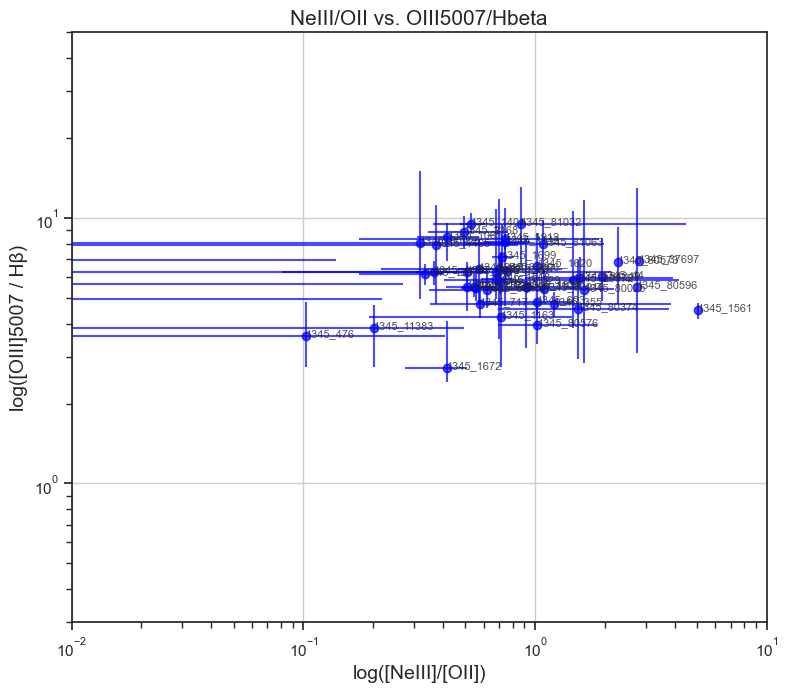

Plotted 47 galaxies


In [ ]:

# Drop rows with NaNs in any key columns
snr_cols = [col for col in ceers_bin_1.columns if col.endswith('SNR')]
base_cols = ['Galaxy ID', 'NeIII_OII_ratio', 'OIII5007_Hbeta_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio_err']

columns_to_keep = base_cols + snr_cols

# Filter the DataFrame, dropping rows with NaNs in the selected columns
valid_data = ceers_bin_1[columns_to_keep].dropna()

import ast
import re

import re
import ast

def clean_and_eval(s):
    # Ensure string type and strip brackets
    s = str(s).strip("[]")
    # Replace all whitespace with commas
    s = re.sub(r'\s+', ',', s)
    # Remove redundant commas
    s = re.sub(r',+', ',', s)
    # Remove leading/trailing commas
    s = s.strip(',')
    # Re-wrap in brackets to form valid list
    s = '[' + s + ']'
    try:
        return ast.literal_eval(s)
    except Exception:
        return [np.nan, np.nan]  # fallback if still bad

# Apply to both columns
valid_data['NeIII_OII_ratio_err'] = valid_data['NeIII_OII_ratio_err'].apply(clean_and_eval)
valid_data['OIII5007_Hbeta_ratio_err'] = valid_data['OIII5007_Hbeta_ratio_err'].apply(clean_and_eval)


x = valid_data['NeIII_OII_ratio'].to_numpy()
y = valid_data['OIII5007_Hbeta_ratio'].to_numpy()
xerr_array = np.vstack(valid_data['NeIII_OII_ratio_err'].tolist()).astype(float)
yerr_array = np.vstack(valid_data['OIII5007_Hbeta_ratio_err'].tolist()).astype(float)

labels = valid_data['Galaxy ID'].to_numpy()
plt.figure(figsize=(8, 7))

# Plot
plt.xlabel('log([NeIII]/[OII])', fontsize=14)
plt.ylabel('log([OIII]5007 / Hβ)', fontsize=14)
plt.title('NeIII/OII vs. OIII5007/Hbeta', fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.errorbar(x, y, xerr=xerr_array.T, yerr=yerr_array.T, fmt='o', color='blue', alpha=0.7)
for xi, yi, label in zip(x, y, labels):
    plt.annotate(label, (xi, yi), fontsize=8, alpha=0.8)
plt.xscale('log')
plt.yscale('log')
sns.set_theme(style="ticks")
plt.xlim(.01, 10)
plt.ylim(.3, 50)
plt.show()

print(f"Plotted {len(labels)} galaxies")


In [ ]:
filter_galaxy(ceers_bin_1, 2.5)

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
5,1345_1027,22.297854,1.053498,"[22.29785422603958, 20.033207642761443]",52.736606,0.982835,"[52.73660629812049, 54.578659670320334]",0.160205,0.108197,197.993264,...,"[23.247205055589674, 15.245421067280688]",438.043321,31.916267,"[14.31142142548174, 13.13811177365102]",1280.588229,82.208072,"[17.156111808101286, 13.998693360019388]",52.973581,2.701556,"[14.162614706104094, 25.054478163364138]"
8,1345_1065,0.000000,0.000000,"[0.0, 0.0]",39.983991,0.966238,"[39.983991224820386, 42.778251326599204]",0.382632,0.092227,139.712367,...,"[11.54901027364403, 17.05870895292729]",437.015883,17.326347,"[25.761219909206886, 24.68402251168243]",1174.609114,46.794971,"[18.942955927729372, 31.259409389725988]",204.063680,3.932024,"[41.21714689433762, 62.578606066521616]"
12,1345_1143,200.628125,5.179191,"[32.4697035438752, 45.004999025302]",124.666074,1.442285,"[124.66607400994491, 48.20689673380815]",0.142258,0.206375,238.935944,...,"[31.04806608538405, 25.594129035211353]",604.531426,29.335265,"[21.553474249472742, 19.661863547571556]",1926.033645,65.227339,"[34.19470216681111, 24.861321868984533]",192.908050,4.564239,"[45.26743375496284, 39.26277450516466]"
17,1345_1334,0.000000,0.000000,"[0.0, 2.0593744193583254]",0.000000,0.000000,"[0.0, 0.0]",0.312276,0.323786,629.928169,...,"[17.321419796718345, 20.392341812355596]",1064.737994,16.613794,"[68.53992282445961, 59.635256671596835]",3449.714692,68.328118,"[53.83840088252737, 47.136565577207875]",258.039131,14.595112,"[16.756961561508064, 18.602701837811765]"
18,1345_1374,147.477559,1.216140,"[147.47755930963385, 95.05621488483496]",148.690134,1.371901,"[103.44098093138223, 113.32413820699935]",0.414943,0.134435,385.977396,...,"[16.30534145723223, 26.88876971520469]",852.364521,17.944279,"[52.11786869404864, 42.88338810672474]",2100.958646,31.326063,"[60.997398934767034, 73.13746676853634]",327.962597,16.237568,"[18.552887367241908, 21.84264509106174]"
20,1345_1401,525.292502,5.568112,"[114.20982237121245, 74.4690318298334]",89.497954,0.373569,"[89.49795399916411, 389.65353023845296]",0.949750,0.155100,280.213480,...,"[25.037409240297734, 22.81736070261735]",726.586641,18.736477,"[36.37829764750734, 41.18021306643311]",2669.248421,53.490206,"[57.63674874415756, 42.166508627244184]",438.691604,13.962601,"[30.35210668791825, 32.48598490010829]"
23,1345_1518,349.069543,3.604239,"[132.03535000553512, 61.66407509859698]",73.365317,0.518471,"[73.36531665551325, 209.64088934773383]",0.379711,0.114146,362.062850,...,"[9.308324724007463, 22.291449979027092]",753.626083,27.713864,"[19.753402479619467, 34.632812177525125]",2149.383756,88.025392,"[30.85708592534911, 17.978453675926175]",186.852773,9.338290,"[16.126143182633655, 23.89248219763988]"
26,1345_1672,281.588845,1.223211,"[281.588844597866, 178.8202694683872]",0.000000,0.000000,"[0.0, 0.0]",0.917070,0.228049,196.161036,...,"[89.83481687602541, 28.347899299528734]",211.304762,14.033486,"[14.559422131486258, 15.554943671082128]",522.080580,18.298239,"[22.423973668586825, 34.63950384208886]",400.807718,18.234913,"[21.076232450888313, 22.884241596647712]"
27,1345_1677,0.000000,0.000000,"[0.0, 76.45351786990652]",0.000000,0.000000,"[0.0, 0.0]",0.358418,0.079157,106.829879,...,"[36.012188527541895, 13.88415043942824]",206.054873,7.830229,"[16.954633423558818, 35.67597904996299]",671.635563,27.603353,"[24.167900745886527, 24.495430665676395]",143.361353,10.833521,"[12.81317504087474, 13.653077574599735]"
29,1345_1699,274.963193,1.688941,"[270.9573959096461, 54.64695627560627]",118.618588,1.129467,"[71.85171454054142, 138.1917268032634]",0.490941,0.123761,355.00107

In [ ]:
#Might have to modify the Ceers Bins 
ceers_bin_2 = get_df('ceers', 100, 4, 7) 

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:130: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: Runti

RMS for 1345_-371 in CIV_window: 0.8068
RMS for 1345_-371 in OII_window: 0.1635
RMS for 1345_-371 in Hb_OIII_window: 0.2375
Final results for 1345_-371: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flu

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


KeyboardInterrupt: 

In [ ]:
# Drop rows with NaNs in any key columns
snr_cols = [col for col in ceers_df.columns if col.endswith('SNR')]
base_cols = ['Galaxy ID', 'NeIII_OII_ratio', 'OIII5007_Hbeta_ratio', 'NeIII_OII_ratio_err', 'OIII5007_Hbeta_ratio_err']

columns_to_keep = base_cols + snr_cols

# Filter the DataFrame, dropping rows with NaNs in the selected columns
valid_data = ceers_df[columns_to_keep]

valid_data

,Galaxy ID,NeIII_OII_ratio,OIII5007_Hbeta_ratio,NeIII_OII_ratio_err,OIII5007_Hbeta_ratio_err
485,1345_-237,NaN,3.649188,[nan nan],[1.96929404 inf]
486,1345_-371,NaN,NaN,[nan nan],[nan nan]
487,1345_1019,NaN,7.071159,[nan nan],[ 3.78991197 32.86468867]
488,1345_1023,NaN,7.882079,[nan nan],[1.69388223 6.33020823]
489,1345_1025,NaN,4.270118,[nan nan],[1.7269797 5.63070065]
...,...,...,...,...,...
625,1345_829,NaN,5.052759,[nan nan],[1.12325397 1.70463636]
626,1345_83592,0.861385,4.439570,[0.56436223 2.11286151],[1.16676051 2.23557958]
627,1345_83764,NaN,2.948577,[nan nan],[1.21442499 4.78697057]
628,1345_83772,0.739993,4.194059,[0.40050539 1.30014762],[1.04903052 2.30617878]


## Uncover Survey

"In Fig. 6, we show the [O III]+Hβ EW distribution of the full JWST-PRIMAL sample and divided into redshift bins: z = 5.0–6.0, z = 6.0–7.0, z = 7.0–8.0, and z = 8.0–9.5." 

### Bin 1

In [ ]:
uncover_bin_1 = get_df('uncover', 100, 4.5, 5.5)
uncover_bin_1

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2561_10686 in CIV_window: 0.5146
RMS for 2561_10686 in OII_window: 0.1214
RMS for 2561_10686 in Hb_OIII_window: 0.1221
Final results for 2561_10686: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 2561_12881 in CIV_window: 0.5123
RMS for 2561_12881 in OII_window: 0.0655
RMS for 2561_12881 in Hb_OIII_window: 0.0508
Final results for 2561_12881: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:130: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 2561_14409 in CIV_window: 0.2309
RMS for 2561_14409 in OII_window: 0.04032
RMS for 2561_14409 in Hb_OIII_window: 0.02902
Final results for 2561_14409: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeII

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
0,2561_10686,0.000000,0.000000,"[0.0, 0.0]",0.000000,0.000000,"[0.0, 107.77248681432022]",0.514606,0.122116,177.542545,...,"[13.853123426202828, 36.3171102858266]",205.881075,19.527914,"[7.984484293925277, 13.101339200345848]",1102.124014,50.367209,"[13.32190566823715, 30.441647713546445]",52.283775,2.375831,"[31.183346301680853, 12.82970059370085]"
1,2561_12881,0.000000,0.000000,"[0.0, 0.0]",0.000000,0.000000,"[0.0, 0.0]",0.512335,0.050804,30.246464,...,"[0.0, 20.372461378297338]",166.823804,1.791504,"[69.10133940066333, 117.1374409061444]",306.468179,4.784210,"[78.35118807365114, 49.765324454619986]",244.083105,2.770275,"[111.19075919022802, 65.02504538506301]"
2,2561_14409,7.973353,0.205402,"[7.9733525062873625, 69.66308753010577]",5.490998,0.118209,"[5.490998109829948, 87.41253542298655]",0.230938,0.029024,19.655100,...,"[8.361075047608576, 17.098442110186603]",-0.000000,0.000000,"[0.0, 0.0]",43.927400,4.284742,"[11.12806846175338, 9.376034825965576]",15.672766,0.926091,"[15.672765748695966, 18.17438486310295]"
3,2561_15719,0.000000,0.000000,"[0.0, 0.0]",0.000000,0.000000,"[0.0, 0.0]",0.475955,0.049305,40.692337,...,"[0.0, 31.297303418265955]",143.342771,2.201161,"[54.84368439050742, 75.39917081768306]",108.656554,3.760774,"[38.3830337205401, 19.401107923819453]",49.500623,2.135668,"[33.80129301372406, 12.554818806817039]"
4,2561_16863,18.442032,0.227463,"[18.4420320064419, 143.71239559140145]",0.000000,0.000000,"[0.0, 0.0]",0.296493,0.290837,329.803501,...,"[13.688575849515132, 12.145859127224952]",903.355712,42.790961,"[18.559940416082895, 23.661860511990085]",2183.504342,98.655879,"[27.174773502414155, 17.09028937076573]",153.834894,13.782797,"[10.169652250744178, 12.153086633545769]"
5,2561_18113,0.000000,0.000000,"[0.0, 0.0]",71.892547,1.159255,"[71.89254666749571, 52.139815496385594]",0.346366,0.036455,9.974925,...,"[59.6412550013803, 72.52546428955705]",11.723076,0.887461,"[11.723076339313021, 14.696279717048064]",72.322336,3.446731,"[18.628230605473924, 23.337523197088785]",5.172807,0.540652,"[5.172806951321451, 13.962640830832179]"
6,2561_18840,0.000000,0.000000,"[0.0, 11.47608709120295]",0.000000,0.000000,"[0.0, 0.0]",0.372260,0.080796,62.983273,...,"[2.1408118237874563, 19.873845680756435]",96.899996,4.201913,"[14.976264015443292, 31.1455859904938]",404.709894,16.313598,"[30.67019552824337, 18.94606873874733]",18.862569,0.651533,"[18.862568535650333, 39.039503599058]"
7,2561_20071,10.038127,0.258133,"[10.03812680575511, 67.73661422971935]",73.575088,1.241573,"[73.57508766363638, 44.94403756848777]",0.276990,0.051230,30.930708,...,"[14.583679002340325, 14.964339894731886]",91.940891,4.375302,"[21.610656940808383, 20.41655982634157]",229.482468,9.901123,"[19.404448691171723, 26.950388341370854]",21.966012,0.992216,"[21.966012295528614, 22.310667105283656]"
8,2561_21527,63.552604,0.827884,"[62.50427404794902, 91.02590961018608]",0.000000,0.000000,"[0.0, 0.0]",0.248145,0.034039,6.161818,...,"[10.05557825184476, 10.099952152569116]",41.065864,2.442756,"[20.44400451516226, 13.178560051906956]",47.534980,4.389706,"[11.114167803534102, 10.543310201128065]",1.382005,0.175050,"[1.38200491868453, 14.407832173654315]"
9,2561_27064,100.670931,1.385252,"[84.52528670082252, 60.82145485388743]",53.222073,0.574656,"[53.222073354047936, 132.00890609897084]",0.632085,0.073707,93.338090,...,"[0.0, 37.04555265335815]",146.395524,2.045860,"[55.994808359696066, 87.11908936947478]",320.492393,7.686905,"[44.25390022058366, 39.132691147236585]",183.191645,5.163489,"[38.884017839893744, 32.0725160487942]"


In [ ]:
max(merged_df[merged_df['survey'] == 'uncover']['z'])

12.908

In [ ]:
snr_cols = [col for col in uncover_bin_1.columns if col.endswith('SNR')]
mask = (uncover_bin_1['NeIII_OII_ratio_SNR'] > 2) & (uncover_bin_1['OIII5007_Hbeta_ratio_SNR'] > 2)
filtered_df = uncover_bin_1[mask]
filtered_df

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
4,2561_16863,18.442032,0.227463,"[18.4420320064419, 143.71239559140145]",0.000000,0.000000,"[0.0, 0.0]",0.296493,0.290837,329.803501,...,"[13.688575849515132, 12.145859127224952]",903.355712,42.790961,"[18.559940416082895, 23.661860511990085]",2183.504342,98.655879,"[27.174773502414155, 17.09028937076573]",153.834894,13.782797,"[10.169652250744178, 12.153086633545769]"
10,2561_27922,0.000000,0.000000,"[0.0, 260.77483267820287]",367.212768,7.906828,"[57.62669159580338, 35.25828841409117]",0.478252,0.108803,298.812026,...,"[21.350042054664385, 13.246796640604813]",791.688317,18.775521,"[43.28822077221764, 41.043746500798306]",1477.879373,39.226957,"[41.002212730902556, 34.34797968093585]",73.146036,3.624977,"[29.023906237680002, 11.332778853456972]"


### Bin 2

In [ ]:
uncover_bin_2 = get_df('uncover', 100, 5.5, 6.5)
uncover_bin_2

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2561_10155 in CIV_window: 0.1794
RMS for 2561_10155 in OII_window: 0.03904
RMS for 2561_10155 in Hb_OIII_window: 0.02358
Final results for 2561_10155: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeII

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:127: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:130: RuntimeWarning: invalid value encountered in scala

RMS for 2561_10740 in CIV_window: 0.2724
RMS for 2561_10740 in OII_window: 0.06101
RMS for 2561_10740 in Hb_OIII_window: 0.0487
Final results for 2561_10740: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:87: RuntimeWarning: divide by zero encountered in divide
  g = fit_g(model, window_wavelength, flux_new[sliced_index], weights=1 / window_flux_err)


RMS for 2561_11045 in CIV_window: 0.2264
RMS for 2561_11045 in OII_window: 0.04894
RMS for 2561_11045 in Hb_OIII_window: 0.06564
Final results for 2561_11045: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeII

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 2561_23541 in CIV_window: 0.2248
RMS for 2561_23541 in OII_window: 0.0426
RMS for 2561_23541 in Hb_OIII_window: 0.05064
Final results for 2561_23541: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


RMS for 2561_8613 in CIV_window: 0.2277
RMS for 2561_8613 in OII_window: 0.05948
RMS for 2561_8613 in Hb_OIII_window: 0.03983
Final results for 2561_8613: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_f

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
0,2561_10155,13.096360,0.385056,"[13.09636031468172, 54.926800524497665]",173.057600,5.160857,"[25.363326776065264, 41.70212844267246]",0.179412,0.023583,48.886271,...,"[17.31085200939722, 21.829038621745454]",59.458707,5.880125,"[9.835839439528336, 10.387782107000803]",192.180758,15.287748,"[12.36376525995783, 12.77803579663373]",0.000000,0.000000,"[0.0, 0.0]"
1,2561_10740,-0.000000,-0.000000,"[50.801709982273515, 0.0]",0.000000,0.000000,"[0.0, 0.0]",0.272391,0.048695,16.603351,...,"[20.637721551422402, 20.36339419930077]",32.794998,2.535537,"[12.030111841498968, 13.83817882040723]",88.349194,4.918197,"[17.501877567800776, 18.425594715108986]",0.000000,0.000000,"[0.0, 18.25566766846111]"
2,2561_11045,4.781964,0.188466,"[4.781964188508596, 45.96419714298962]",0.000000,0.000000,"[0.0, 0.0]",0.226365,0.065636,142.493370,...,"[8.20785244466471, 22.962046538141742]",290.587494,23.050517,"[10.638845314329956, 14.574254297564437]",817.706702,61.427921,"[13.05074742121235, 13.572543352704884]",241.394174,10.168670,"[28.49762917816173, 18.980392586987875]"
3,2561_12065,188.657663,2.337105,"[103.05701381347723, 58.38861176917209]",0.000000,0.000000,"[0.0, 13.110372734657675]",0.358681,0.058789,19.768787,...,"[29.87891168338661, 40.04566703530113]",58.630454,6.639707,"[8.407068075038346, 9.253487003408274]",148.210622,9.601694,"[13.501615609777161, 17.37014808072101]",1.770644,0.046050,"[1.7706444491831723, 75.1296935315365]"
4,2561_13821,0.000000,0.000000,"[0.0, 49.53573376819655]",0.000000,0.000000,"[0.0, 113.31242264470868]",0.180420,0.047589,139.378603,...,"[14.397187317384159, 51.307264375614565]",132.180478,7.766477,"[20.247403676917287, 13.79131794459488]",341.250744,26.405375,"[16.544846349711804, 9.302220129820569]",24.749016,1.806722,"[14.876304677575853, 12.520284090643052]"
5,2561_14354,0.000000,0.000000,"[0.0, 148.83927759962094]",183.789473,1.730484,"[164.92642172778832, 47.487517174874114]",0.476839,0.150284,127.185287,...,"[104.17998874511778, 17.74148479734079]",248.978273,12.678771,"[16.949769200894423, 22.325058778994645]",962.816336,44.713002,"[22.420936235991917, 20.645567804966277]",262.208291,13.390570,"[15.043887021919744, 24.11923771701339]"
6,2561_15227,26.473776,0.510089,"[26.473775840809566, 77.32679940771611]",0.000000,0.000000,"[0.0, 0.0]",0.283279,0.034394,79.296838,...,"[13.691937383871384, 11.579478468855061]",116.708934,6.719426,"[16.856181622403597, 17.881589127388025]",325.587930,14.689553,"[20.49475153459258, 23.83442998036213]",34.226783,2.140131,"[13.049727460308585, 18.9359595715246]"
7,2561_15265,0.000000,0.000000,"[0.0, 38.72236667400938]",32.105746,0.292093,"[32.10574558374593, 187.7265671907403]",0.377706,0.044753,38.874785,...,"[11.63184422496424, 16.551045242001017]",16.986177,0.714221,"[9.969564163992025, 37.59605653205496]",85.833257,4.927548,"[17.149712564519575, 17.688407384377584]",0.000000,0.000000,"[0.0, 17.585390065242947]"
8,2561_16942,136.142231,1.876624,"[97.7208339070327, 47.37185574594264]",20.578552,0.409376,"[20.578552316217948, 79.95751827235007]",0.257923,0.055868,10.670462,...,"[0.05362046189865128, 24.475120314811846]",7.964681,0.725569,"[7.964680530475654, 13.989624350812594]",77.619016,7.739408,"[8.076230204077717, 11.981897900184833]",48.231681,2.363008,"[22.298421309187734, 18.52385160747916]"
9,2561_20972,0.000000,0.000000,"[0.0, 86.2972088486545]",34.524607,0.786043,"[34.524606925386294, 53.31943502587123]",0.212947,0.031838,22.003408,...,"[7.479660386341209, 13.158691119922096]",49.362801,3.302608,"[18.2044221659921, 11.688798963029441]",79.250053,4.657109,"[18.248895483435383, 15.

In [ ]:
filter_galaxy(uncover_bin_2, 2.5)

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
13,2561_23608,0.000000,0.000000,"[0.0, 331.27626357316103]",261.366564,1.535687,"[261.36656368464855, 79.02392601712279]",0.370771,0.136836,631.773449,...,"[14.99595296343466, 18.080060656018958]",961.316673,39.399469,"[24.729396145358464, 24.069062807554246]",3390.309130,111.791426,"[35.860008214453046, 24.794180402845996]",170.786605,2.618106,"[15.514875105590988, 114.95088219690336]"
21,2561_28110,100.801894,0.794770,"[100.80189445412904, 152.8612892346316]",67.788226,0.734937,"[67.78822564939902, 116.68524518870039]",0.439570,0.119311,244.578253,...,"[15.169381824192186, 11.841562227988106]",718.425304,27.532225,"[30.987141989907627, 21.20081549069755]",1671.718166,59.223700,"[26.030628964165317, 30.423734962062554]",429.826517,22.911122,"[17.1886800182005, 20.332530163210436]"
32,2561_35488,165.275675,0.925877,"[165.27567471466452, 191.73863778377878]",0.000000,0.000000,"[0.0, 0.0]",0.310273,0.112444,649.610204,...,"[18.80987982867981, 34.930512240924145]",1257.089886,67.312160,"[18.102888510039747, 19.248160293059527]",3548.036442,124.864145,"[28.22313229841484, 28.60721622959818]",145.059706,12.190767,"[9.784333644925312, 14.013957402804266]"
52,2561_8943,283.567471,3.911665,"[108.89009388475137, 36.09545218273786]",0.000000,0.000000,"[0.0, 30.423636298308065]",0.539291,0.115594,303.710105,...,"[15.147105360155308, 12.047919321866885]",747.836755,30.784349,"[24.129500319964905, 24.45601735989635]",1960.242557,72.929248,"[27.651559248297872, 26.105818280159156]",123.567053,10.587740,"[9.727106252341528, 13.614428160578129]"


In [ ]:
uncover_bin_3 = get_df('uncover', 100, 6.5, 7.5)
uncover_bin_3

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2561_11254 in CIV_window: 0.1027
RMS for 2561_11254 in OII_window: 0.02806
RMS for 2561_11254 in Hb_OIII_window: 0.06059
Final results for 2561_11254: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeII

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:130: RuntimeWarning: divide by zero encountered in scal

RMS for 2561_12899 in CIV_window: 0.07813
RMS for 2561_12899 in OII_window: 0.02693
RMS for 2561_12899 in Hb_OIII_window: 0.02075
Final results for 2561_12899: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeI

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:130: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:124: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 2561_37537 in CIV_window: 0.1136
RMS for 2561_37537 in OII_window: 0.0557
RMS for 2561_37537 in Hb_OIII_window: 0.05339
Final results for 2561_37537: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
0,2561_11254,0.000000,0.000000,"[0.0, 101.81800360540068]",173.369999,3.340772,"[82.05966194890509, 21.73073219375516]",0.102672,0.060592,151.142925,...,"[3.990921463222591, 4.075535339158115]",163.477211,23.725541,"[7.042264630995447, 6.738429150829063]",425.271692,64.429804,"[6.843668114197442, 6.3574178796963565]",19.533894,1.678249,"[19.533894438389865, 3.7450052815765567]"
1,2561_12899,68.558624,0.351753,"[68.55862380121748, 321.2527919571134]",29.395791,0.967741,"[29.395790897730073, 31.35554736769751]",0.078130,0.020751,20.829666,...,"[5.537143510759845, 0.0]",10.565437,1.655048,"[6.220428641244844, 6.547101711640096]",32.364445,4.286128,"[5.711671303861543, 9.390277565208862]",1.868716,0.365704,"[1.8687158711768368, 8.351122329167163]"
2,2561_13123,17.872916,1.140692,"[17.872915565846384, 13.464041597313916]",5.243255,0.268618,"[5.243254692027984, 33.79547743534434]",0.047752,0.054176,121.725908,...,"[7.609553708182103, 2.617825307503871]",11.567834,0.915899,"[11.567833724403041, 13.69223461196595]",20.581259,1.730222,"[17.88213002490594, 5.908183908286059]",0.000000,0.000000,"[0.0, 0.0]"
3,2561_15383,29.781695,1.325569,"[20.905927712956128, 24.028270781918224]",69.068052,2.663470,"[40.71623798039035, 11.146972518394563]",0.087394,0.078397,161.493418,...,"[20.150243743304088, 3.577243175132331]",0.000000,0.000000,"[0.0, 7.496562742659356]",33.035881,3.571807,"[14.754392683888248, 3.7437408397563274]",0.000000,0.000000,"[0.0, 1.8547830627214659]"
4,2561_16155,23.537126,0.551320,"[23.53712600837907, 61.8474853112805]",68.238280,1.646924,"[64.6875498963265, 18.179980835371182]",0.089690,0.031117,68.998764,...,"[15.885089907090938, 14.18994592544793]",76.711981,11.672929,"[6.6587277141927075, 6.4848420881510975]",259.205016,39.705551,"[6.857971226749896, 6.1983903076340425]",7.871759,0.956691,"[7.871758730680401, 8.584466053628617]"
5,2561_16594,5.132384,0.341653,"[5.132383581305245, 24.912072945205264]",0.000000,0.000000,"[0.0, 0.0]",0.051155,0.033930,75.612302,...,"[0.0, 3.376396440190441]",11.885893,2.585147,"[7.178351210232538, 2.01717525574076]",12.088585,3.610128,"[4.031735418090237, 2.6653036318054095]",4.874250,1.090152,"[4.874249846151476, 4.068082031557828]"
6,2561_2008,0.000000,0.000000,"[0.0, 32.510349252458454]",34.189084,0.684930,"[34.18908354747161, 65.64321708172072]",0.102813,0.035714,40.708890,...,"[25.722027249851102, 15.44305861167566]",6.062025,0.646096,"[6.0620254307971635, 12.703063559373849]",55.412433,6.532357,"[9.520811838231197, 7.444713378816907]",2.689166,0.228657,"[2.689165645544911, 20.832261510053698]"
7,2561_23619,-5.024948,-0.601083,"[11.694690181183457, 5.024947893825934]",-10.864391,-0.639341,"[23.12183928213249, 10.864390602559858]",0.062903,0.027749,15.783011,...,"[4.007739834885857, 4.770671771985114]",17.602110,5.872091,"[2.552441523971753, 3.4427343209812804]",58.416649,14.456898,"[3.724263222256809, 4.357227976665044]",0.000000,0.000000,"[0.0, 5.000160494923394]"
8,2561_27335,0.000000,0.000000,"[0.0, 11.094697672599466]",0.000000,0.000000,"[0.0, 8.04634487856106]",0.081510,0.021229,17.188603,...,"[1.9548336156495978, 8.927704429405155]",9.745182,1.155457,"[9.383314460115296, 7.484792051420186]",37.772228,6.611021,"[5.664837591859353, 5.7622106823480905]",2.303916,0.547767,"[2.3039156969091277, 6.108109936614547]"
9,2561_28876,41.341206,1.059869,"[29.166913593257853, 48.84499915423048]",6.616751,0.283693,"[6.616751100209525, 40.03046759938333]",0.075487,0.025245,81.697584,...,"[0.0, 5.782698912269273]",15.421198,4.079577,"[4.339952811335474, 3.2202415481314883]",27.220245,2.849773,"[6.0846814535218

In [ ]:
filter_galaxy(uncover_bin_3, 2.5)

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
16,2561_43709,34.069517,1.465353,"[23.07664496668339, 23.423442980470057]",76.591165,2.302174,"[46.872971774651475, 19.665151699917047]",0.082111,0.023308,32.156068,...,"[6.236101939953993, 4.639513840860506]",49.443943,4.285588,"[11.88132133813783, 11.19320101858009]",101.890022,17.534175,"[5.652925873431613, 5.96895189717398]",27.150997,4.570849,"[5.554005335460456, 6.3260626599087075]"


In [ ]:
uncover_bin_4 = get_df('uncover', 100, 7.5, 8.5)
uncover_bin_4

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2561_18924 in CIV_window: 0.0464
RMS for 2561_18924 in OII_window: 0.01734
RMS for 2561_18924 in Hb_OIII_window: 0.02536
Final results for 2561_18924: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeII

c:\Users\isaia\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: invalid value encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2561_23604 in CIV_window: 0.05362
RMS for 2561_23604 in OII_window: 0.02614
RMS for 2561_23604 in Hb_OIII_window: 0.03292
Final results for 2561_23604: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'MgI_5174_flux', 'MgI_5174_flux_err', 'MgI_5174_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeI

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['OIII5007_Hbeta_ratio'] = iteration_fluxes['[OIII]_5007_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:127: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hdelta_Hbeta_ratio'] = iteration_fluxes['Hdelta_flux'] / iteration_fluxes['Hbeta_flux']
C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:130: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['Hgamma_Hbeta_ratio'] = iteration_fluxes['Hgammma_OIII_flux'] / iteration_fluxes['Hbeta_flux']


RMS for 2561_38059 in CIV_window: 0.07954
RMS for 2561_38059 in OII_window: 0.09113
RMS for 2561_38059 in Hb_OIII_window: 0.05963
Final results for 2561_38059: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'N

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
0,2561_18924,0.0,0.0,"[0.0, 0.0]",5.061615,0.446370,"[5.061615226438281, 17.617413465621578]",0.046399,0.025358,28.209260,...,"[11.159357336016434, 7.035402616808572]",62.860854,9.197548,"[6.189867348523428, 7.479178716999925]",137.858316,27.167261,"[5.031382090499477, 5.1174741959080166]",6.253914,0.841931,"[6.253913622183926, 8.602206370754448]"
1,2561_23604,0.0,0.0,"[0.0, 31.844745918024728]",98.538117,4.242858,"[20.69110114307783, 25.757837625530712]",0.053618,0.032921,53.746248,...,"[8.23358984087024, 9.252220255390776]",23.991986,2.528248,"[6.74390373297603, 12.23523373975986]",110.778176,12.432664,"[9.020367935178825, 8.800137151058706]",0.000000,0.000000,"[0.0, 8.448656450999664]"
2,2561_24531,0.0,0.0,"[0.0, 23.531567957654904]",0.000000,0.000000,"[0.0, 22.265467679646083]",0.160128,0.093453,209.174308,...,"[47.3774844484081, 17.94479798721673]",440.559896,36.439040,"[11.208057374737962, 12.97259601311356]",1207.645594,68.961283,"[13.80424828736659, 21.21962426207392]",112.794698,4.307950,"[19.711757596524663, 32.65407962434732]"
3,2561_38059,0.0,0.0,"[0.0, 0.0]",0.000000,0.000000,"[0.0, 0.0]",0.079543,0.059633,33.942025,...,"[0.0, 10.279558165579926]",23.520307,1.623904,"[10.827545430713299, 18.14005705469747]",128.344171,10.174523,"[15.059103656846446, 10.169434994859643]",51.892740,3.552471,"[15.394146166298725, 13.820867449148146]"
4,2561_60157,0.0,0.0,"[0.0, 0.8967057073290069]",0.000000,0.000000,"[0.0, 0.0]",0.095318,0.049976,43.570420,...,"[3.0469794488852884, 22.972286002551314]",138.867916,7.065826,"[17.870035382299747, 21.436879664629004]",332.571999,29.760447,"[12.94327794262449, 9.406655323801772]",157.554539,12.477213,"[12.635353367427768, 12.61941146359922]"


In [ ]:
filter_galaxy(uncover_bin_4, 2.5)

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
2,2561_24531,0.0,0.0,"[0.0, 23.531567957654904]",0.0,0.0,"[0.0, 22.265467679646083]",0.160128,0.093453,209.174308,...,"[47.3774844484081, 17.94479798721673]",440.559896,36.439040,"[11.208057374737962, 12.97259601311356]",1207.645594,68.961283,"[13.80424828736659, 21.21962426207392]",112.794698,4.307950,"[19.711757596524663, 32.65407962434732]"
4,2561_60157,0.0,0.0,"[0.0, 0.8967057073290069]",0.0,0.0,"[0.0, 0.0]",0.095318,0.049976,43.570420,...,"[3.0469794488852884, 22.972286002551314]",138.867916,7.065826,"[17.870035382299747, 21.436879664629004]",332.571999,29.760447,"[12.94327794262449, 9.406655323801772]",157.554539,12.477213,"[12.635353367427768, 12.61941146359922]"


In [ ]:
uncover_bin_5 = get_df('uncover', 100, 8.5, 9.5)
uncover_bin_5

c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


RMS for 2561_10646 in CIV_window: 0.2681
RMS for 2561_10646 in OII_window: 0.1818
RMS for 2561_10646 in Hb_OIII_window: 1.123
Final results for 2561_10646: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'NeIII

C:\Users\isaia\AppData\Local\Temp\ipykernel_11004\3805839533.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  iteration_ratios['NeIII_OII_ratio'] = iteration_fluxes['[NeIII]_flux'] / iteration_fluxes['[OII]_doublet_flux']


RMS for 2561_20466 in CIV_window: 0.1021
RMS for 2561_20466 in OII_window: 0.05736
RMS for 2561_20466 in Hb_OIII_window: 0.1057
Final results for 2561_20466: dict_keys(['CIV_window_fit_rms', 'OII_window_fit_rms', 'Hb_OIII_window_fit_rms', 'Hdelta_flux', 'Hdelta_flux_err', 'Hdelta_flux_SNR', 'Hgammma_OIII_flux', 'Hgammma_OIII_flux_err', 'Hgammma_OIII_flux_SNR', '[OII]_doublet_flux', '[OII]_doublet_flux_err', '[OII]_doublet_flux_SNR', 'Hbeta_flux', 'Hbeta_flux_err', 'Hbeta_flux_SNR', 'CIII]_doublet_flux', 'CIII]_doublet_flux_err', 'CIII]_doublet_flux_SNR', '[OIII]_5007_flux', '[OIII]_5007_flux_err', '[OIII]_5007_flux_SNR', 'Hepsilon_flux', 'Hepsilon_flux_err', 'Hepsilon_flux_SNR', 'OIII]_doublet_flux', 'OIII]_doublet_flux_err', 'OIII]_doublet_flux_SNR', 'CIV_doublet_flux', 'CIV_doublet_flux_err', 'CIV_doublet_flux_SNR', '[OIII]_4959_flux', '[OIII]_4959_flux_err', '[OIII]_4959_flux_SNR', '[NeIII]_flux', '[NeIII]_flux_err', '[NeIII]_flux_SNR', 'NeIII_OII_ratio', 'NeIII_OII_ratio_err', 'NeI

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
0,2561_10646,600.660780,23.702525,"[22.15237072867592, 28.530903921101867]",613.266966,26.935426,"[24.34889093422646, 21.18719694699996]",0.268092,1.123404,994.239925,...,"[46.587787214102775, 31.05272155525131]",2917.07340,121.174118,"[25.118980150281914, 23.02782627661736]",7258.266306,256.551517,"[25.2368099761934, 31.34649465209077]",243.923012,20.510499,"[7.2271293932167, 16.5580564267608]"
1,2561_20466,32.506925,0.773488,"[32.50692481278767, 51.54592209412439]",25.351487,0.777890,"[25.351487240654045, 39.82862948317685]",0.102093,0.105672,237.420562,...,"[17.562263725496074, 16.185623758836925]",178.89727,9.153598,"[20.53414625281718, 18.553713408512124]",457.014140,28.432121,"[14.91508781010998, 17.232647256600842]",24.705201,1.767460,"[12.354284148903194, 15.601310210206897]"


In [ ]:
filter_galaxy(uncover_bin_5, 2.5)

,Galaxy ID,CIII]_doublet_flux,CIII]_doublet_flux_SNR,CIII]_doublet_flux_err,CIV_doublet_flux,CIV_doublet_flux_SNR,CIV_doublet_flux_err,CIV_window_fit_rms,Hb_OIII_window_fit_rms,Hbeta_flux,...,[NeIII]_flux_err,[OIII]_4959_flux,[OIII]_4959_flux_SNR,[OIII]_4959_flux_err,[OIII]_5007_flux,[OIII]_5007_flux_SNR,[OIII]_5007_flux_err,[OII]_doublet_flux,[OII]_doublet_flux_SNR,[OII]_doublet_flux_err
0,2561_10646,600.66078,23.702525,"[22.15237072867592, 28.530903921101867]",613.266966,26.935426,"[24.34889093422646, 21.18719694699996]",0.268092,1.123404,994.239925,...,"[46.587787214102775, 31.05272155525131]",2917.0734,121.174118,"[25.118980150281914, 23.02782627661736]",7258.266306,256.551517,"[25.2368099761934, 31.34649465209077]",243.923012,20.510499,"[7.2271293932167, 16.5580564267608]"


In [ ]:
uncover_bin_6 = get_df('uncover', 100, 9.5, 10)
uncover_bin_6

Failed on 2561_13151 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Failed on 2561_22223 due to: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.
Processed 0 galaxies


c:\Users\isaia\anaconda3\Lib\site-packages\astropy\modeling\functional_models.py:218: RuntimeWarning: divide by zero encountered in divide
  return amplitude * np.exp(-0.5 * (x - mean) ** 2 / stddev**2)


,Galaxy ID
